In [1]:
cd ../..

D:\Users\mrefoyo\Proyectos\Sub-SpaCE_plus


In [2]:
import os
import pickle
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
import seaborn as sns
import plotly.express as px

from experiments.evaluation.evaluation_utils import load_dataset_for_eval, calculate_metrics_for_dataset, calculate_metrics_for_dataset_mp

print(tf.__version__)

2.13.0


In [39]:
# DATASETS = ['CBF', 'chinatown', 'coffee', 'gunpoint', 'ECG200']
DATASETS = [
    "BasicMotions", "NATOPS", "UWaveGestureLibrary",
    'ArticularyWordRecognition', 'Cricket', 'Epilepsy', 
    # 'PenDigits', 
    # 'PEMS-SF',
    'RacketSports', 'SelfRegulationSCP1'
]

MO_UTILITY = np.array([0.1, 0.4*0.7, 0.6*0.7, 0.2])
model_to_explain = "inceptiontime_noscaling"
scaling = "none"
osc_names = {"AE": "ae_basic_train", "IF": "if_basic_train", "LOF": "lof_basic_train"}
methods = {
    # Comparison between single objective and multi objective ordered by same weights
    # "comte": "COMTE",
    # "abcf": "AB-CF",
    # "discox": "DiscoX",
    # "69b0c08cb89f3affa34a887b03c1fb0355f6284a": "MultiSub-SpaCE", # ("multisubspace_gknn_75_0_25_prmut05")
    
    # "abd6be72d2e5c0967af2134fe463ff2ad9250524": "Sub-SpaCE",
    # "7dbaa6cfdb5cd23ba93e6495b43a5f2874fd79c0": "multisubspace_gknn_75_25_0",
    # "b4a4daf2c1791e984fb1ec07dfe589ddf9caf4bb": "multisubspace_gknn_cch_55_100",
    # "be4d9b4ba2ab19d5089defeb5d1e10f5ab372b65": "multisubspace_gknn_75_0_25",

    # Compparison between pruning incorporated in the process vs 25 iterations of only prunning
    # "be4d9b4ba2ab19d5089defeb5d1e10f5ab372b65": "multisubspace_gknn_75_0_25",
    # "5f46fc7707574df97f58cbdea5a22eb059521b8d": "integrated_prunning_gknn_0_100_0",

    # Comparison between initialization
    # "827e5a1dcdef171654915c3a6044f696b45907f5": "multisubspace_gknn_75_0_25_fi_none",
    # "be4d9b4ba2ab19d5089defeb5d1e10f5ab372b65": "multisubspace_gknn_75_0_25_fi_gradcam",

    # New mutation experiments (fi none)
    # "98115f1aa11842ba52440c2efcae5b9f5dad10f2": "multisubspace_gknn_75_0_25_mut01",
    # "afd19a8e19ebb2a3aa36f377a7ed81f0c2d55f16": "multisubspace_gknn_75_0_25_mut02",
    # "1cf037d1e4512683b378b90ee9345de26d09def6": "multisubspace_gknn_75_0_25_mut03",
    # "e04c4795bf5b47b47d660f78ff50f2038e16fdfd": "multisubspace_gknn_75_0_25_mut04",
    # "2f59f6a9fb383e5e87357b4c64b422836b2921a6": "multisubspace_gknn_75_0_25_mut05",
    # "565064e37e308e5881221745d22763d8fa51b37a": "multisubspace_gknn_75_0_25_mut06",
    # "9c3070b31c45e8f9197e4fb4f62e9e02cb687b45": "multisubspace_gknn_75_0_25_mut07",
    # "d06c42645d15ba3573722b600ebbf593455ef748": "multisubspace_gknn_75_0_25_mut08",
    # "e87b5e0754f69e5d00651bc87a34567cf82fe6e3": "multisubspace_gknn_75_0_25_mut09",

    # New mutation experiments pruning (fi none)
    # "19f0de6299f82c9ab47d1d46c6ea83ee54dfe691": "multisubspace_gknn_75_0_25_prmut005",
    # "4aafe4d4ccb244b2446d66b8608600205b942787": "multisubspace_gknn_75_0_25_prmut01",
    # "a237cc2d28cfe6f9add64a179b2fa7b4d747853a": "multisubspace_gknn_75_0_25_prmut02",
    # "e9ebdff05a145a76c31f2cbe438e1a32e5c5473a": "multisubspace_gknn_75_0_25_prmut03",
    # "a33c5446ce679cedb83991068c270831efa47975": "multisubspace_gknn_75_0_25_prmut04",
    # "69b0c08cb89f3affa34a887b03c1fb0355f6284a": "multisubspace_gknn_75_0_25_prmut05",
    # "9e9a7a01b4824d2f58291cc086174576a5dcbcfe": "multisubspace_gknn_75_0_25_prmut06",
    # "ac7c5b42b1036baf33e912ab9a9613893cd6b843": "multisubspace_gknn_75_0_25_prmut07",
    # "89092d7641759abfb5841f049b37396865a9d775": "multisubspace_gknn_75_0_25_prmut08",
    # "4c06abd19829ede45f8c5bc3c958b0b3a3a2d6db": "multisubspace_gknn_75_0_25_prmut09",

    # EC mutation experiments (Common mask)
    "f676325b0b1c36c3b483537a7e7e57a47533a7e3": "multisubspace_100_0_0_ecmut01",
    "33f3475138f13c48b70e73cb7fb0914c598ae104": "multisubspace_100_0_0_ecmut025",
    "e9865c3b9818978aad085c5523559ef83acb141d": "multisubspace_100_0_0_ecmut05",
    "c5fc53e1bf194d16a1354452d556a31178ee0a88": "multisubspace_100_0_0_ecmut075",
    "cc0bbfc12b0585495ce8c9ea04fa360d842ac5c4": "multisubspace_100_0_0_ecmut09",

    # EC mutation experiments (Independent mask)
    "facc49754a7993cd1faa4cd8b844cbbf33a7d2f8": "multisubspace_0_100_0_ecmut01",
    "402f3e69237a356e9da139fdb944a198da5ab78c": "multisubspace_0_100_0_ecmut025",
    "092e9256990841c035e9d3524d02a49772aca4c7": "multisubspace_0_100_0_ecmut05",
    "6f94c99e9ec09c5b37981d9c923e4994e85c9f23": "multisubspace_0_100_0_ecmut075",
    "65d3e0068fd2b3a26f8ca05ab8d5f476859d8054": "multisubspace_0_100_0_ecmut09",

    # IPR mutation experiments (Common mask) 
    # "ffc3071aa361488419da609865a6727d87e5fb90": "multisubspace_100_0_0_ecmut075",
    # "a637bc423783498d207e9dda3ab7dbd731e9a5e1": "multisubspace_100_0_0_iprmut005",
    # "6e26a9c3971ebd6650c3a13fec84ce2da94745d2": "multisubspace_100_0_0_iprmut01",
    # "212b6d7f7b13032dd640af18818a8f386a13fda0": "multisubspace_100_0_0_iprmut02",
    # # "94b669c9b61bed442ecb15ed4d5990bab047af16": "multisubspace_100_0_0_iprmut025",
    # "bb352a5c349c64faa6826ed76fe99689596491f8": "multisubspace_100_0_0_iprmut035",
    # "1f3f4ad4573e92f66866a087631235a41bfc0c12": "multisubspace_100_0_0_iprmut05",
    # # "7d18ae015ce34b6a1d9b402ebae814153fda14c5": "multisubspace_100_0_0_iprmut075",
    # # "cfe0077fd88ca25ad3f27b263bb971e27f964fc9": "multisubspace_100_0_0_iprmut09",

    # IPR mutation experiments (Independent mask) 
    # "ab7a867102b50f24504b7ad92da408fd9a9b563f": "multisubspace_0_100_0_ecmut05",
    # "2603d798caf49ed7564030ae33fbfeac8b7dad78": "multisubspace_0_100_0_iprmut005",
    # "7f4ad301ee140fe43babd635f92dfe874b87e577": "multisubspace_0_100_0_iprmut01",
    # "58c2870a9a8e2384f28153f7c27d4135b4356bb1": "multisubspace_0_100_0_iprmut02",
    # "d53b1be50eaa09837716d4bcbf3e3754d54903a3": "multisubspace_0_100_0_iprmut035",
    # "d7e242f837d82cdf400b6c65818c8c6fea4f7270": "multisubspace_0_100_0_iprmut05",

    # Comparison between best of E/C & pruning mutations
    # "ffc3071aa361488419da609865a6727d87e5fb90": "100_0_0_ec075_ipr0",
    # "ab7a867102b50f24504b7ad92da408fd9a9b563f": "0_100_0_ec05_ipr0",
    # "a637bc423783498d207e9dda3ab7dbd731e9a5e1": "100_0_0_ec075_ipr005",
    # "2603d798caf49ed7564030ae33fbfeac8b7dad78": "0_100_0_iprmut005",
    # "69b0c08cb89f3affa34a887b03c1fb0355f6284a": "MultiSub-SpaCE", # ("multisubspace_gknn_75_0_25_prmut05")

    # Comparison with 25 it of only pruning
    # "52c707d0a60c5ae3e485079cf31b7110e927c046": "75_0_25_ec075_ipr_0_fpr_005",
    # "edfbb8c0e4c8e1a12f8b20b79e8e33e58afa93e8": "75_0_25_ec075_ipr_0_fpr_01",
    # "34a6ccfbe93ea4ba95ce17f4ca5b375794ec7c30": "75_0_25_ec075_ipr_0_fpr_015",
    # "ea6b2c57f79a83f542ffb6162378522a256feaa0": "75_0_25_ec075_ipr_0_fpr_025",
    # "d98ff072a62c4346b035510c421f3498e40f8bbc": "75_0_25_ec075_ipr_0_fpr_05",
    # "b36c8d082cce22e71013de720ae958cea4bd301a": "75_0_25_ec075_ipr_0_fpr_075",
    
    # "cfe91aeb7062e8ee0d278420c5aa63158de472c4": "0_75_25_ec05_ipr_0_fpr_005",
    # "c8a57ddcb4f712686c376fdf0e6f30dbdc2a67bd": "0_75_25_ec05_ipr_0_fpr_01",
    # "a21f8ed3c41eb5b3b359b767af109a94dd1b3ce3": "0_75_25_ec05_ipr_0_fpr_015",
    # "7fab1a78543898e7ab587c55e4c5114188d97b92": "0_75_25_ec05_ipr_0_fpr_025",
    # "5f78a77da6bbc7aa4d60aceb28b8ec13c280d93b": "0_75_25_ec05_ipr_0_fpr_05",
    # "4deca39559544db6730686308bb85a439292c397": "0_75_25_ec05_ipr_0_fpr_075",

    # Time comparison
    # "d8387d902c6723a9106adc62d4fc6f327a8bd275": "MS-SpaCE(parallel)",
    # "ede366e48b604d46d44fb2b8565445aa7eb08323": "MS-SpaCE"
}

# Get results

In [40]:
# Data and aux data dict
data_dict = {}
models_dict = {}
outlier_calculators_dict = {}
possible_nuns_dict = {}
desired_classes_dict = {}
original_classes_dict = {}

# Results dicts
mean_results_dict = {}
methods_cfs_dict = {}
results_all_datasets_df = pd.DataFrame()
common_test_indexes_dict = {}

# Iterate through datasets
for dataset in DATASETS:
    print(f'Calculating metrics for {dataset}')
    # Load all info needed to get the counterfactual
    data_tuple, original_classes, model, outlier_calculators, possible_nuns, desired_classes = load_dataset_for_eval(dataset, model_to_explain, osc_names, scaling=scaling)
    data_dict[dataset] = data_tuple
    models_dict[dataset] = model
    outlier_calculators_dict[dataset] = outlier_calculators
    possible_nuns_dict[dataset] = possible_nuns
    desired_classes_dict[dataset] = desired_classes
    original_classes_dict[dataset] = original_classes

    # Get the metrics for all methods
    dataset_mean_std_df, dataset_results_df, method_cfs_dataset, common_test_indexes = calculate_metrics_for_dataset(
        dataset, methods, model_to_explain,
        data_tuple, original_classes, model, outlier_calculators, possible_nuns,
        mo_weights=MO_UTILITY
    )
    mean_results_dict[dataset] = dataset_mean_std_df
    methods_cfs_dict[dataset] = method_cfs_dataset
    results_all_datasets_df = pd.concat([results_all_datasets_df, dataset_results_df])
    common_test_indexes_dict[dataset] = common_test_indexes

    # Store results
    # dataset_mean_std_df.to_csv(f'./experiments/evaluation/results_mean_metrics_{dataset}.csv', sep=";", index=False)

# Store all results
# results_all_datasets_df.to_csv(f'./experiments/evaluation/results_all.csv', sep=";", index=False)


Calculating metrics for BasicMotions
Calculating metrics for NATOPS
Calculating metrics for UWaveGestureLibrary
Calculating metrics for ArticularyWordRecognition
Calculating metrics for Cricket
Calculating metrics for Epilepsy
Calculating metrics for RacketSports
Calculating metrics for SelfRegulationSCP1


In [41]:
from IPython.display import display
for dataset in DATASETS:
    print(dataset)
    display(mean_results_dict[dataset])

BasicMotions


method            ii        nchanges     sparsity               L1             L2        proba      valid nuns_valid        AE_OS        IF_OS       LOF_OS       AE_IOS       IF_IOS    LOF_IOS  subsequences subsequences %           times  best cf index
0   multisubspace_0_100_0_ecmut05  19.5 ± 11.69   150.0 ± 81.65  0.25 ± 0.14  700.95 ± 671.15    68.4 ± 48.8   0.8 ± 0.15  1.0 ± 0.0  1.0 ± 0.0   0.33 ± 0.2   0.26 ± 0.2  0.04 ± 0.07  0.02 ± 0.03   0.0 ± 0.01  0.0 ± 0.0   9.02 ± 3.85    0.03 ± 0.01  157.19 ± 41.06  15.22 ± 19.79
1  multisubspace_100_0_0_ecmut025  19.5 ± 11.69  264.75 ± 97.96  0.44 ± 0.16  806.31 ± 679.14   70.1 ± 48.09  0.84 ± 0.11  1.0 ± 0.0  1.0 ± 0.0  0.26 ± 0.16  0.23 ± 0.18  0.05 ± 0.09  0.01 ± 0.02  0.01 ± 0.01  0.0 ± 0.0    9.6 ± 4.86    0.03 ± 0.02   110.03 ± 1.52  46.85 ± 32.85
2  multisubspace_0_100_0_ecmut025  19.5 ± 11.69  158.72 ± 83.75  0.26 ± 0.14  729.24 ± 679.79   70.5 ± 50.06  0.81 ± 0.14  1.0 ± 0.0  1.0 ± 0.0   0.33 ± 0.2   0.25 ± 0.2  0.04 ± 0.07  0.02 ± 0.03   0.0 ± 0.01  0.0 ± 0.0  11.95 ± 5.01    0.04 ± 0.02  149.48 ± 45.99  11.78 ± 14.06
3   multisubspace_0_100_0_ecmut09  19.5 ± 11.69   155.88 ± 91.3  0.26 ± 0.15  741.53 ± 729.22  70.28 ± 51.68   0.8 ± 0.14  1.0 ± 0.0  1.0 ± 0.0  0.33 ± 0.19   0.25 ± 0.2  0.03 ± 0.06  0.02 ± 0.03   0.0 ± 0.01  0.0 ± 0.0   14.2 ± 22.0    0.05 ± 0.07  201.32 ± 48.41  18.42 ± 19.02
4  multisubspace_0_100_0_ecmut075  19.5 ± 11.69  153.72 ± 88.24  0.26 ± 0.15  731.72 ± 702.32   69.9 ± 50.76   0.8 ± 0.14  1.0 ± 0.0  1.0 ± 0.0   0.33 ± 0.2   0.25 ± 0.2  0.03 ± 0.06  0.02 ± 0.03   0.0 ± 0.01  0.0 ± 0.0  12.0 ± 22.14    0.04 ± 0.07   177.02 ± 49.9  12.52 ± 16.79
5  multisubspace_100_0_0_ecmut075  19.5 ± 11.69  256.05 ± 89.62  0.43 ± 0.15  768.86 ± 613.72  68.23 ± 46.21  0.79 ± 0.12  1.0 ± 0.0  1.0 ± 0.0  0.26 ± 0.16  0.25 ± 0.19  0.06 ± 0.09  0.01 ± 0.02  0.01 ± 0.01  0.0 ± 0.0   8.55 ± 3.82    0.03 ± 0.01   118.39 ± 21.5  51.05 ± 30.21
6   multisubspace_100_0_0_ecmut09  19.5 ± 11.69  240.45 ± 92.72   0.4 ± 0.15  750.62 ± 612.01  68.02 ± 46.26  0.77 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.27 ± 0.16  0.25 ± 0.19  0.06 ± 0.09  0.01 ± 0.02  0.01 ± 0.02  0.0 ± 0.0   12.3 ± 5.25    0.04 ± 0.02  118.92 ± 24.68   51.38 ± 32.7
7   multisubspace_100_0_0_ecmut05  19.5 ± 11.69  256.23 ± 91.51  0.43 ± 0.15   776.2 ± 624.17  68.66 ± 47.15   0.8 ± 0.12  1.0 ± 0.0  1.0 ± 0.0  0.26 ± 0.16  0.24 ± 0.19  0.05 ± 0.09  0.01 ± 0.02  0.01 ± 0.01  0.0 ± 0.0   8.85 ± 5.43    0.03 ± 0.02   112.02 ± 1.33  47.02 ± 26.98
8   multisubspace_100_0_0_ecmut01  19.5 ± 11.69  244.38 ± 89.21  0.41 ± 0.15  761.43 ± 633.99  68.39 ± 46.78   0.8 ± 0.14  1.0 ± 0.0  1.0 ± 0.0  0.27 ± 0.17  0.25 ± 0.19  0.05 ± 0.09  0.01 ± 0.02  0.01 ± 0.02  0.0 ± 0.0   12.75 ± 6.1    0.04 ± 0.02  111.42 ± 11.45  38.35 ± 32.53
9   multisubspace_0_100_0_ecmut01  19.5 ± 11.69   171.8 ± 98.63  0.29 ± 0.16  770.83 ± 739.97  71.71 ± 51.87  0.82 ± 0.14  1.0 ± 0.0  1.0 ± 0.0  0.32 ± 0.18  0.24 ± 0.18  0.03 ± 0.05  0.02 ± 0.03  0.01 ± 0.01  0.0 ± 0.0  21.48 ± 9.94    0.07 ± 0.03  159.04 ± 49.43  18.35 ± 18.41

NATOPS


method             ii         nchanges     sparsity               L1           L2        proba      valid nuns_valid        AE_OS        IF_OS       LOF_OS       AE_IOS       IF_IOS      LOF_IOS   subsequences subsequences %           times  best cf index
0   multisubspace_0_100_0_ecmut05  87.18 ± 53.72  190.31 ± 137.26  0.16 ± 0.11  102.87 ± 101.22  8.52 ± 6.15  0.89 ± 0.13  1.0 ± 0.0  1.0 ± 0.0  0.69 ± 0.27  0.29 ± 0.17   0.21 ± 0.2  0.14 ± 0.14   0.0 ± 0.01  0.01 ± 0.02   25.33 ± 14.8    0.04 ± 0.02  113.92 ± 34.67  11.25 ± 14.94
1  multisubspace_100_0_0_ecmut025  87.18 ± 53.72    267.6 ± 97.11  0.22 ± 0.08   128.29 ± 97.32  9.56 ± 6.06  0.94 ± 0.05  1.0 ± 0.0  1.0 ± 0.0  0.57 ± 0.19  0.28 ± 0.17  0.19 ± 0.19  0.03 ± 0.04  0.01 ± 0.02  0.01 ± 0.02    24.24 ± 2.4     0.04 ± 0.0   89.34 ± 18.08  54.74 ± 30.21
2  multisubspace_0_100_0_ecmut025  87.18 ± 53.72  215.12 ± 131.84  0.18 ± 0.11  112.12 ± 104.31  8.86 ± 6.26   0.9 ± 0.13  1.0 ± 0.0  1.0 ± 0.0  0.68 ± 0.26  0.28 ± 0.16   0.2 ± 0.19  0.14 ± 0.13   0.0 ± 0.02   0.0 ± 0.02  34.68 ± 15.66    0.06 ± 0.03  110.87 ± 32.29  14.44 ± 19.18
3   multisubspace_0_100_0_ecmut09  87.18 ± 53.72  199.25 ± 164.82  0.16 ± 0.13  108.14 ± 105.77  8.59 ± 6.34  0.86 ± 0.15  1.0 ± 0.0  1.0 ± 0.0  0.69 ± 0.29  0.29 ± 0.17    0.2 ± 0.2  0.14 ± 0.15   0.0 ± 0.01   0.0 ± 0.02  44.82 ± 74.38    0.07 ± 0.12  136.81 ± 47.57   14.3 ± 19.67
4  multisubspace_0_100_0_ecmut075  87.18 ± 53.72   186.25 ± 151.0  0.15 ± 0.12  103.08 ± 103.41  8.46 ± 6.25  0.89 ± 0.14  1.0 ± 0.0  1.0 ± 0.0  0.67 ± 0.27  0.29 ± 0.17   0.21 ± 0.2  0.13 ± 0.13   0.0 ± 0.02  0.01 ± 0.02   26.06 ± 37.2    0.04 ± 0.06   130.58 ± 47.6  17.93 ± 23.56
5  multisubspace_100_0_0_ecmut075  87.18 ± 53.72   266.64 ± 97.62  0.22 ± 0.08   127.91 ± 97.71  9.54 ± 6.08  0.93 ± 0.05  1.0 ± 0.0  1.0 ± 0.0  0.57 ± 0.19  0.28 ± 0.17  0.19 ± 0.19  0.03 ± 0.04  0.01 ± 0.02  0.01 ± 0.02     24.0 ± 0.0     0.04 ± 0.0    89.2 ± 16.14  49.84 ± 32.19
6   multisubspace_100_0_0_ecmut09  87.18 ± 53.72   265.44 ± 98.21  0.22 ± 0.08   127.03 ± 95.68  9.52 ± 6.01  0.93 ± 0.05  1.0 ± 0.0  1.0 ± 0.0  0.57 ± 0.19  0.28 ± 0.17  0.19 ± 0.19  0.03 ± 0.04  0.01 ± 0.02  0.01 ± 0.02     24.0 ± 0.0     0.04 ± 0.0   90.14 ± 11.07  49.33 ± 33.87
7   multisubspace_100_0_0_ecmut05  87.18 ± 53.72   267.36 ± 99.04  0.22 ± 0.08   128.76 ± 99.18  9.56 ± 6.11  0.94 ± 0.05  1.0 ± 0.0  1.0 ± 0.0  0.57 ± 0.19  0.27 ± 0.16  0.19 ± 0.19  0.03 ± 0.04  0.01 ± 0.02  0.01 ± 0.02     24.0 ± 0.0     0.04 ± 0.0   88.28 ± 15.32  55.58 ± 28.38
8   multisubspace_100_0_0_ecmut01  87.18 ± 53.72   267.36 ± 98.63  0.22 ± 0.08   128.59 ± 98.39  9.57 ± 6.11  0.94 ± 0.04  1.0 ± 0.0  1.0 ± 0.0  0.57 ± 0.19  0.27 ± 0.16  0.19 ± 0.19  0.03 ± 0.04  0.01 ± 0.02  0.01 ± 0.02    24.24 ± 2.4     0.04 ± 0.0    88.5 ± 14.16  46.13 ± 30.83
9   multisubspace_0_100_0_ecmut01  87.18 ± 53.72  257.02 ± 148.29  0.21 ± 0.12  117.18 ± 101.71  8.97 ± 6.04  0.91 ± 0.12  1.0 ± 0.0  1.0 ± 0.0  0.71 ± 0.28  0.28 ± 0.17    0.2 ± 0.2  0.16 ± 0.15   0.0 ± 0.02   0.0 ± 0.02  61.95 ± 27.03     0.1 ± 0.04   111.83 ± 35.0  13.32 ± 15.96

UWaveGestureLibrary


method             ii         nchanges     sparsity               L1            L2        proba      valid nuns_valid        AE_OS        IF_OS       LOF_OS       AE_IOS       IF_IOS      LOF_IOS  subsequences subsequences %            times  best cf index
0   multisubspace_0_100_0_ecmut05  159.0 ± 87.23  177.95 ± 126.48  0.19 ± 0.13   187.7 ± 113.46   15.68 ± 5.5  0.65 ± 0.17  1.0 ± 0.0  1.0 ± 0.0  0.63 ± 0.16  0.44 ± 0.23  0.41 ± 0.22  0.12 ± 0.12   0.07 ± 0.1   0.06 ± 0.1   5.26 ± 4.47    0.01 ± 0.01  436.95 ± 148.75  28.36 ± 28.82
1  multisubspace_100_0_0_ecmut025  159.0 ± 87.23  286.98 ± 136.05   0.3 ± 0.14  252.01 ± 124.45   17.7 ± 5.83  0.74 ± 0.14  1.0 ± 0.0  1.0 ± 0.0   0.6 ± 0.14  0.43 ± 0.24   0.4 ± 0.22  0.09 ± 0.09  0.07 ± 0.12  0.07 ± 0.12   5.91 ± 3.06    0.01 ± 0.01   345.91 ± 46.82  43.01 ± 36.13
2  multisubspace_0_100_0_ecmut025  159.0 ± 87.23  186.22 ± 128.78   0.2 ± 0.14  197.19 ± 116.59  16.23 ± 5.51  0.68 ± 0.18  1.0 ± 0.0  1.0 ± 0.0  0.65 ± 0.17  0.44 ± 0.23   0.4 ± 0.22  0.14 ± 0.13   0.06 ± 0.1  0.06 ± 0.11    6.51 ± 4.9    0.01 ± 0.01  406.05 ± 149.13  27.76 ± 28.44
3   multisubspace_0_100_0_ecmut09  159.0 ± 87.23  199.24 ± 134.07  0.21 ± 0.14   202.38 ± 123.3  16.15 ± 5.93  0.64 ± 0.18  1.0 ± 0.0  1.0 ± 0.0  0.77 ± 0.44  0.45 ± 0.24   0.4 ± 0.22  0.25 ± 0.42   0.06 ± 0.1   0.06 ± 0.1   13.6 ± 32.6    0.03 ± 0.07   572.6 ± 167.29  27.08 ± 31.66
4  multisubspace_0_100_0_ecmut075  159.0 ± 87.23  182.33 ± 131.32  0.19 ± 0.14  193.05 ± 119.95  15.95 ± 5.79  0.64 ± 0.17  1.0 ± 0.0  1.0 ± 0.0  0.63 ± 0.16  0.43 ± 0.23   0.4 ± 0.23  0.11 ± 0.13  0.05 ± 0.09  0.06 ± 0.12   5.19 ± 3.76    0.01 ± 0.01  510.64 ± 156.44  24.12 ± 26.72
5  multisubspace_100_0_0_ecmut075  159.0 ± 87.23  276.06 ± 126.94  0.29 ± 0.13  243.35 ± 118.68  17.41 ± 5.69  0.71 ± 0.16  1.0 ± 0.0  1.0 ± 0.0   0.6 ± 0.14  0.43 ± 0.26  0.41 ± 0.25  0.09 ± 0.08  0.07 ± 0.12  0.08 ± 0.15   5.91 ± 2.75    0.01 ± 0.01   370.47 ± 81.69  40.12 ± 35.32
6   multisubspace_100_0_0_ecmut09  159.0 ± 87.23  262.83 ± 132.71  0.28 ± 0.14  230.48 ± 122.67  16.78 ± 5.86  0.67 ± 0.17  1.0 ± 0.0  1.0 ± 0.0  0.63 ± 0.14  0.46 ± 0.24  0.43 ± 0.25  0.12 ± 0.11  0.08 ± 0.12  0.09 ± 0.16    6.6 ± 3.13    0.01 ± 0.01  425.39 ± 125.01   32.17 ± 32.6
7   multisubspace_100_0_0_ecmut05  159.0 ± 87.23  288.09 ± 135.34   0.3 ± 0.14  251.62 ± 122.41  17.66 ± 5.57  0.74 ± 0.18  1.0 ± 0.0  1.0 ± 0.0  0.59 ± 0.13  0.44 ± 0.26  0.41 ± 0.25  0.08 ± 0.08  0.09 ± 0.12  0.08 ± 0.15   5.58 ± 2.56    0.01 ± 0.01   345.9 ± 103.32  42.25 ± 37.04
8   multisubspace_100_0_0_ecmut01  159.0 ± 87.23   276.27 ± 127.7  0.29 ± 0.14  243.65 ± 119.39  17.43 ± 5.73  0.72 ± 0.16  1.0 ± 0.0  1.0 ± 0.0  0.62 ± 0.14  0.45 ± 0.25  0.41 ± 0.25   0.11 ± 0.1  0.08 ± 0.12  0.08 ± 0.15   6.48 ± 3.13    0.01 ± 0.01   355.83 ± 56.77  31.01 ± 33.09
9   multisubspace_0_100_0_ecmut01  159.0 ± 87.23  217.06 ± 146.55  0.23 ± 0.16  208.21 ± 131.53  16.17 ± 5.97  0.64 ± 0.19  1.0 ± 0.0  1.0 ± 0.0  0.77 ± 0.25  0.44 ± 0.24   0.4 ± 0.21  0.25 ± 0.19   0.06 ± 0.1  0.05 ± 0.09  12.99 ± 9.17    0.03 ± 0.02  458.47 ± 134.97  18.74 ± 24.79

ArticularyWordRecognition


method              ii         nchanges     sparsity               L1            L2        proba      valid nuns_valid        AE_OS        IF_OS       LOF_OS       AE_IOS       IF_IOS      LOF_IOS   subsequences subsequences %           times  best cf index
0   multisubspace_0_100_0_ecmut05  145.05 ± 81.17  325.57 ± 203.44  0.25 ± 0.16  266.98 ± 157.38  17.86 ± 6.07   0.62 ± 0.2  1.0 ± 0.0  1.0 ± 0.0   0.7 ± 0.14  0.49 ± 0.19   0.3 ± 0.18  0.07 ± 0.07  0.04 ± 0.07  0.03 ± 0.05  22.74 ± 11.26    0.04 ± 0.02  282.59 ± 92.37  13.58 ± 17.75
1  multisubspace_100_0_0_ecmut025  145.05 ± 81.17  452.25 ± 192.07  0.35 ± 0.15  332.24 ± 152.42  19.38 ± 5.76   0.64 ± 0.2  1.0 ± 0.0  1.0 ± 0.0  0.64 ± 0.13  0.47 ± 0.19   0.3 ± 0.19  0.03 ± 0.06  0.05 ± 0.07  0.03 ± 0.06   12.87 ± 4.83    0.02 ± 0.01  192.73 ± 39.72  48.24 ± 33.86
2  multisubspace_0_100_0_ecmut025  145.05 ± 81.17  340.05 ± 190.26  0.26 ± 0.15  273.23 ± 153.25  17.92 ± 5.97   0.61 ± 0.2  1.0 ± 0.0  1.0 ± 0.0  0.71 ± 0.14  0.47 ± 0.19  0.29 ± 0.18  0.09 ± 0.08  0.03 ± 0.06  0.03 ± 0.05  31.86 ± 15.95    0.05 ± 0.02  256.59 ± 95.57  16.34 ± 21.48
3   multisubspace_0_100_0_ecmut09  145.05 ± 81.17   386.2 ± 216.86   0.3 ± 0.17  299.35 ± 166.63  18.65 ± 6.28   0.6 ± 0.21  1.0 ± 0.0  1.0 ± 0.0  0.77 ± 0.18  0.46 ± 0.19  0.29 ± 0.18  0.14 ± 0.14  0.03 ± 0.05  0.03 ± 0.05  74.42 ± 95.08    0.11 ± 0.15  339.59 ± 94.11  13.06 ± 17.01
4  multisubspace_0_100_0_ecmut075  145.05 ± 81.17  335.53 ± 204.62  0.26 ± 0.16  273.93 ± 161.16  18.03 ± 6.25  0.62 ± 0.19  1.0 ± 0.0  1.0 ± 0.0  0.71 ± 0.15  0.48 ± 0.18  0.29 ± 0.18   0.08 ± 0.1  0.04 ± 0.06  0.03 ± 0.05   30.2 ± 43.73    0.05 ± 0.07  321.27 ± 94.42  14.04 ± 16.73
5  multisubspace_100_0_0_ecmut075  145.05 ± 81.17   440.28 ± 191.5  0.34 ± 0.15   325.36 ± 150.1  19.26 ± 5.74   0.62 ± 0.2  1.0 ± 0.0  1.0 ± 0.0  0.65 ± 0.13  0.48 ± 0.19  0.29 ± 0.18  0.03 ± 0.05  0.05 ± 0.08  0.03 ± 0.06   12.96 ± 5.32    0.02 ± 0.01  191.17 ± 63.21  53.49 ± 29.26
6   multisubspace_100_0_0_ecmut09  145.05 ± 81.17   435.6 ± 189.07  0.34 ± 0.15  322.43 ± 150.93   19.2 ± 5.72  0.61 ± 0.19  1.0 ± 0.0  1.0 ± 0.0  0.65 ± 0.14  0.48 ± 0.19   0.3 ± 0.19  0.03 ± 0.05  0.05 ± 0.07  0.03 ± 0.06   14.22 ± 5.45    0.02 ± 0.01  200.72 ± 53.15  43.14 ± 32.65
7   multisubspace_100_0_0_ecmut05  145.05 ± 81.17   447.03 ± 197.9  0.34 ± 0.15  326.47 ± 152.76  19.24 ± 5.66   0.62 ± 0.2  1.0 ± 0.0  1.0 ± 0.0  0.64 ± 0.14  0.47 ± 0.18   0.3 ± 0.18  0.03 ± 0.05  0.05 ± 0.08  0.03 ± 0.06    12.33 ± 4.9    0.02 ± 0.01  187.56 ± 49.85   46.62 ± 32.2
8   multisubspace_100_0_0_ecmut01  145.05 ± 81.17  452.07 ± 185.48  0.35 ± 0.14   329.8 ± 146.44   19.3 ± 5.68  0.64 ± 0.21  1.0 ± 0.0  1.0 ± 0.0  0.65 ± 0.14   0.48 ± 0.2   0.3 ± 0.19  0.04 ± 0.05  0.05 ± 0.08  0.03 ± 0.06   14.13 ± 5.76    0.02 ± 0.01   190.82 ± 21.4  44.73 ± 34.04
9   multisubspace_0_100_0_ecmut01  145.05 ± 81.17  396.76 ± 202.54  0.31 ± 0.16  310.78 ± 161.79  19.18 ± 6.12   0.64 ± 0.2  1.0 ± 0.0  1.0 ± 0.0  0.75 ± 0.15  0.46 ± 0.18  0.28 ± 0.17  0.12 ± 0.09  0.03 ± 0.05  0.02 ± 0.04  59.28 ± 24.22    0.09 ± 0.04  270.66 ± 75.23  16.77 ± 18.64

Cricket


method            ii           nchanges     sparsity                 L1             L2        proba      valid nuns_valid        AE_OS        IF_OS       LOF_OS       AE_IOS       IF_IOS      LOF_IOS     subsequences subsequences %             times  best cf index
0   multisubspace_0_100_0_ecmut05  35.5 ± 20.93  3696.64 ± 1549.44  0.51 ± 0.22  2651.13 ± 1158.07  61.99 ± 17.03  0.65 ± 0.18  1.0 ± 0.0  1.0 ± 0.0  0.84 ± 0.27  0.28 ± 0.17  0.11 ± 0.18  0.19 ± 0.22  0.01 ± 0.03   0.0 ± 0.01  175.08 ± 198.95    0.05 ± 0.06  2164.71 ± 761.32  21.04 ± 18.13
1  multisubspace_100_0_0_ecmut025  35.5 ± 20.93  3388.25 ± 1421.63   0.47 ± 0.2  2211.62 ± 1076.18  54.68 ± 17.26  0.63 ± 0.18  1.0 ± 0.0  1.0 ± 0.0  0.69 ± 0.19  0.28 ± 0.17   0.12 ± 0.2  0.06 ± 0.08  0.02 ± 0.04   0.0 ± 0.02    54.92 ± 22.98    0.02 ± 0.01  1555.56 ± 616.83  36.35 ± 34.99
2  multisubspace_0_100_0_ecmut025  35.5 ± 20.93  3810.31 ± 1694.89  0.53 ± 0.24  2685.81 ± 1212.81  62.15 ± 17.47   0.65 ± 0.2  1.0 ± 0.0  1.0 ± 0.0  0.85 ± 0.24  0.27 ± 0.16  0.11 ± 0.17   0.21 ± 0.2  0.01 ± 0.03   0.0 ± 0.02    192.6 ± 88.45    0.05 ± 0.02  2123.08 ± 783.64   23.5 ± 22.58
3   multisubspace_0_100_0_ecmut09  35.5 ± 20.93   4273.5 ± 1524.27   0.6 ± 0.21   3027.4 ± 1151.59  66.47 ± 17.12  0.58 ± 0.21  1.0 ± 0.0  1.0 ± 0.0  1.05 ± 0.41  0.27 ± 0.17  0.11 ± 0.17   0.4 ± 0.38  0.01 ± 0.04   0.0 ± 0.01  703.38 ± 681.73     0.2 ± 0.19  2501.03 ± 858.65   17.28 ± 22.6
4  multisubspace_0_100_0_ecmut075  35.5 ± 20.93  3798.28 ± 1566.35  0.53 ± 0.22  2736.72 ± 1198.36  63.04 ± 17.18  0.58 ± 0.19  1.0 ± 0.0  1.0 ± 0.0  0.93 ± 0.35  0.28 ± 0.18  0.12 ± 0.18  0.28 ± 0.32  0.02 ± 0.03   0.0 ± 0.01  320.54 ± 413.21    0.09 ± 0.12  2257.36 ± 811.93  16.42 ± 19.22
5  multisubspace_100_0_0_ecmut075  35.5 ± 20.93  3341.17 ± 1470.24   0.47 ± 0.2  2239.87 ± 1097.79  55.53 ± 17.89  0.61 ± 0.18  1.0 ± 0.0  1.0 ± 0.0  0.68 ± 0.18  0.29 ± 0.16   0.12 ± 0.2  0.06 ± 0.07  0.02 ± 0.04  0.01 ± 0.03    51.08 ± 21.95    0.01 ± 0.01  1831.46 ± 695.31  31.36 ± 31.99
6   multisubspace_100_0_0_ecmut09  35.5 ± 20.93   3637.25 ± 1487.7  0.51 ± 0.21  2455.95 ± 1103.11  58.99 ± 16.22  0.62 ± 0.18  1.0 ± 0.0  1.0 ± 0.0    0.8 ± 0.3  0.29 ± 0.17   0.12 ± 0.2  0.17 ± 0.27  0.02 ± 0.04  0.01 ± 0.03  246.58 ± 475.97    0.07 ± 0.13  2044.13 ± 698.64  36.67 ± 34.99
7   multisubspace_100_0_0_ecmut05  35.5 ± 20.93  3237.08 ± 1364.99  0.45 ± 0.19  2125.58 ± 1054.81   53.5 ± 17.47  0.61 ± 0.19  1.0 ± 0.0  1.0 ± 0.0  0.67 ± 0.17  0.29 ± 0.16  0.13 ± 0.21  0.05 ± 0.06  0.02 ± 0.04  0.01 ± 0.03    44.58 ± 19.91    0.01 ± 0.01   1603.8 ± 609.27  36.47 ± 32.91
8   multisubspace_100_0_0_ecmut01  35.5 ± 20.93  3588.25 ± 1568.25   0.5 ± 0.22  2386.91 ± 1139.73  57.38 ± 17.38  0.63 ± 0.18  1.0 ± 0.0  1.0 ± 0.0   0.73 ± 0.2  0.28 ± 0.16  0.12 ± 0.19  0.09 ± 0.12  0.02 ± 0.04   0.0 ± 0.02   106.25 ± 45.79    0.03 ± 0.01  1665.31 ± 662.18  32.04 ± 33.34
9   multisubspace_0_100_0_ecmut01  35.5 ± 20.93  4106.53 ± 1681.45  0.57 ± 0.23   2907.26 ± 1215.5  64.93 ± 17.82  0.63 ± 0.18  1.0 ± 0.0  1.0 ± 0.0  0.94 ± 0.29  0.28 ± 0.17  0.11 ± 0.16  0.29 ± 0.25  0.02 ± 0.03   0.0 ± 0.01   325.9 ± 157.43    0.09 ± 0.04  2244.26 ± 895.54  17.68 ± 19.93

Epilepsy


method             ii        nchanges     sparsity              L1            L2        proba      valid nuns_valid        AE_OS        IF_OS       LOF_OS       AE_IOS       IF_IOS     LOF_IOS   subsequences subsequences %            times  best cf index
0   multisubspace_0_100_0_ecmut05  68.51 ± 38.95  202.33 ± 82.38  0.33 ± 0.13   160.6 ± 67.62  13.51 ± 4.39  0.78 ± 0.12  1.0 ± 0.0  1.0 ± 0.0  0.56 ± 0.18  0.28 ± 0.15   0.1 ± 0.11  0.03 ± 0.06  0.03 ± 0.06  0.0 ± 0.01     5.55 ± 2.8    0.02 ± 0.01   323.16 ± 92.12  21.74 ± 24.32
1  multisubspace_100_0_0_ecmut025  68.51 ± 38.95  296.64 ± 85.88  0.48 ± 0.14  193.16 ± 72.77  14.13 ± 4.52  0.79 ± 0.12  1.0 ± 0.0  1.0 ± 0.0  0.54 ± 0.14  0.27 ± 0.12    0.1 ± 0.1  0.03 ± 0.05  0.03 ± 0.05  0.0 ± 0.01    7.28 ± 3.27    0.02 ± 0.01   248.28 ± 41.31  45.77 ± 35.17
2  multisubspace_0_100_0_ecmut025  68.51 ± 38.95  201.62 ± 79.53  0.33 ± 0.13   158.36 ± 64.7  13.37 ± 4.26  0.78 ± 0.13  1.0 ± 0.0  1.0 ± 0.0  0.57 ± 0.19  0.29 ± 0.16  0.11 ± 0.12  0.04 ± 0.06  0.03 ± 0.05  0.0 ± 0.01    8.54 ± 4.37    0.03 ± 0.01   299.13 ± 88.61   24.8 ± 25.01
3   multisubspace_0_100_0_ecmut09  68.51 ± 38.95   218.72 ± 88.4  0.35 ± 0.14  166.33 ± 68.48  13.62 ± 4.41  0.78 ± 0.13  1.0 ± 0.0  1.0 ± 0.0  0.59 ± 0.18  0.28 ± 0.15   0.1 ± 0.11  0.05 ± 0.07  0.02 ± 0.05  0.0 ± 0.01  19.25 ± 31.56     0.06 ± 0.1  464.54 ± 105.66  24.45 ± 23.16
4  multisubspace_0_100_0_ecmut075  68.51 ± 38.95  202.82 ± 87.57  0.33 ± 0.14  160.05 ± 65.48  13.46 ± 4.19   0.8 ± 0.12  1.0 ± 0.0  1.0 ± 0.0  0.57 ± 0.18  0.29 ± 0.16  0.11 ± 0.12  0.04 ± 0.06  0.03 ± 0.05  0.0 ± 0.01    6.46 ± 3.61    0.02 ± 0.01   395.68 ± 98.32   22.6 ± 21.61
5  multisubspace_100_0_0_ecmut075  68.51 ± 38.95  292.34 ± 82.34  0.47 ± 0.13  190.11 ± 71.35  14.03 ± 4.52  0.78 ± 0.11  1.0 ± 0.0  1.0 ± 0.0  0.54 ± 0.14  0.27 ± 0.12    0.1 ± 0.1  0.03 ± 0.05  0.03 ± 0.06  0.0 ± 0.01    7.02 ± 3.11    0.02 ± 0.01    256.59 ± 65.0  50.01 ± 31.95
6   multisubspace_100_0_0_ecmut09  68.51 ± 38.95  282.95 ± 83.09  0.46 ± 0.13  186.57 ± 71.99  13.93 ± 4.52  0.76 ± 0.12  1.0 ± 0.0  1.0 ± 0.0  0.56 ± 0.15  0.27 ± 0.12   0.1 ± 0.11  0.03 ± 0.05  0.03 ± 0.05  0.0 ± 0.01    9.28 ± 3.79    0.03 ± 0.01   309.07 ± 76.59  47.64 ± 31.49
7   multisubspace_100_0_0_ecmut05  68.51 ± 38.95  300.63 ± 80.89  0.49 ± 0.13   195.7 ± 74.38  14.22 ± 4.61   0.8 ± 0.12  1.0 ± 0.0  1.0 ± 0.0  0.53 ± 0.13  0.26 ± 0.12   0.09 ± 0.1  0.03 ± 0.05  0.03 ± 0.05  0.0 ± 0.01     6.3 ± 2.97    0.02 ± 0.01    241.96 ± 66.2  49.45 ± 33.29
8   multisubspace_100_0_0_ecmut01  68.51 ± 38.95  291.21 ± 82.44  0.47 ± 0.13  190.13 ± 69.41  14.06 ± 4.43  0.79 ± 0.12  1.0 ± 0.0  1.0 ± 0.0  0.56 ± 0.16  0.28 ± 0.13    0.1 ± 0.1  0.03 ± 0.05  0.03 ± 0.05  0.0 ± 0.01   10.59 ± 6.13    0.03 ± 0.02   241.72 ± 41.62  44.74 ± 35.27
9   multisubspace_0_100_0_ecmut01  68.51 ± 38.95  217.44 ± 97.23  0.35 ± 0.16   164.3 ± 71.55  13.49 ± 4.38  0.79 ± 0.13  1.0 ± 0.0  1.0 ± 0.0  0.59 ± 0.19  0.28 ± 0.15  0.11 ± 0.11  0.04 ± 0.06  0.02 ± 0.04  0.0 ± 0.01   19.67 ± 8.44    0.06 ± 0.03   322.05 ± 96.02  26.77 ± 26.49

RacketSports


method             ii       nchanges     sparsity               L1             L2        proba      valid nuns_valid        AE_OS        IF_OS       LOF_OS       AE_IOS       IF_IOS      LOF_IOS subsequences subsequences %          times  best cf index
0   multisubspace_0_100_0_ecmut05  74.15 ± 41.52  21.23 ± 12.58  0.12 ± 0.07   181.21 ± 82.85    49.9 ± 13.7  0.81 ± 0.14  1.0 ± 0.0  1.0 ± 0.0  0.71 ± 0.14  0.33 ± 0.16   0.12 ± 0.1  0.02 ± 0.03  0.01 ± 0.02  0.01 ± 0.01   3.25 ± 1.7    0.04 ± 0.02   93.82 ± 22.8  15.41 ± 18.59
1  multisubspace_100_0_0_ecmut025  74.15 ± 41.52  37.69 ± 19.52  0.21 ± 0.11  283.01 ± 105.25  61.69 ± 14.47  0.85 ± 0.12  1.0 ± 0.0  1.0 ± 0.0  0.62 ± 0.17  0.28 ± 0.18   0.09 ± 0.1  0.01 ± 0.03  0.01 ± 0.03  0.01 ± 0.02  6.18 ± 1.03    0.07 ± 0.01   95.82 ± 5.41  54.66 ± 34.25
2  multisubspace_0_100_0_ecmut025  74.15 ± 41.52  20.94 ± 11.65  0.12 ± 0.06     183.2 ± 83.3  50.15 ± 14.03  0.83 ± 0.13  1.0 ± 0.0  1.0 ± 0.0  0.71 ± 0.14  0.33 ± 0.16  0.11 ± 0.09  0.02 ± 0.03  0.01 ± 0.02   0.0 ± 0.01  3.91 ± 2.19    0.04 ± 0.02  96.12 ± 10.75  17.48 ± 22.24
3   multisubspace_0_100_0_ecmut09  74.15 ± 41.52  18.41 ± 11.19   0.1 ± 0.06   169.71 ± 82.81  48.87 ± 13.37  0.78 ± 0.13  1.0 ± 0.0  1.0 ± 0.0  0.72 ± 0.14  0.34 ± 0.16  0.12 ± 0.09  0.02 ± 0.03  0.01 ± 0.02   0.0 ± 0.01  3.37 ± 2.02    0.04 ± 0.02  109.11 ± 26.9   16.0 ± 21.32
4  multisubspace_0_100_0_ecmut075  74.15 ± 41.52  19.99 ± 12.35  0.11 ± 0.07   177.76 ± 85.44   49.56 ± 13.6  0.81 ± 0.12  1.0 ± 0.0  1.0 ± 0.0  0.71 ± 0.14  0.33 ± 0.16   0.12 ± 0.1  0.02 ± 0.03  0.01 ± 0.02   0.0 ± 0.01  3.08 ± 1.39    0.03 ± 0.02  99.55 ± 20.08  18.33 ± 20.91
5  multisubspace_100_0_0_ecmut075  74.15 ± 41.52  38.47 ± 20.28  0.21 ± 0.11  284.68 ± 106.08  61.71 ± 14.48  0.86 ± 0.11  1.0 ± 0.0  1.0 ± 0.0  0.61 ± 0.17  0.28 ± 0.18   0.09 ± 0.1  0.01 ± 0.03  0.01 ± 0.03  0.01 ± 0.02  6.12 ± 0.84    0.07 ± 0.01   93.15 ± 7.44  53.01 ± 33.84
6   multisubspace_100_0_0_ecmut09  74.15 ± 41.52  37.63 ± 18.85   0.21 ± 0.1  282.29 ± 100.81  61.65 ± 14.24  0.85 ± 0.13  1.0 ± 0.0  1.0 ± 0.0  0.62 ± 0.17  0.28 ± 0.18   0.09 ± 0.1  0.01 ± 0.03  0.01 ± 0.03  0.01 ± 0.02  6.18 ± 1.03    0.07 ± 0.01   91.8 ± 10.53   60.88 ± 34.5
7   multisubspace_100_0_0_ecmut05  74.15 ± 41.52  37.33 ± 18.37   0.21 ± 0.1  282.04 ± 102.22  61.62 ± 14.34  0.85 ± 0.12  1.0 ± 0.0  1.0 ± 0.0  0.62 ± 0.17  0.28 ± 0.18   0.09 ± 0.1  0.01 ± 0.03  0.01 ± 0.03  0.01 ± 0.02  6.18 ± 1.03    0.07 ± 0.01  89.53 ± 16.17  53.65 ± 34.58
8   multisubspace_100_0_0_ecmut01  74.15 ± 41.52   37.27 ± 18.7   0.21 ± 0.1  280.99 ± 102.87  61.55 ± 14.42  0.85 ± 0.12  1.0 ± 0.0  1.0 ± 0.0  0.62 ± 0.17  0.28 ± 0.18   0.09 ± 0.1  0.01 ± 0.03  0.01 ± 0.03  0.01 ± 0.02  6.36 ± 1.67    0.07 ± 0.02  87.86 ± 16.79  49.47 ± 34.64
9   multisubspace_0_100_0_ecmut01  74.15 ± 41.52  20.07 ± 11.55  0.11 ± 0.06   182.46 ± 82.35  51.23 ± 12.93  0.82 ± 0.13  1.0 ± 0.0  1.0 ± 0.0   0.7 ± 0.14  0.33 ± 0.16   0.12 ± 0.1  0.01 ± 0.03  0.01 ± 0.02  0.01 ± 0.02  4.65 ± 3.39    0.05 ± 0.04   96.28 ± 9.02   14.6 ± 20.12

SelfRegulationSCP1


method              ii          nchanges     sparsity                   L1               L2        proba      valid nuns_valid        AE_OS        IF_OS       LOF_OS       AE_IOS      IF_IOS    LOF_IOS     subsequences subsequences %             times  best cf index
0   multisubspace_0_100_0_ecmut05  145.63 ± 82.65   714.16 ± 578.42  0.13 ± 0.11  10208.41 ± 12070.04  394.73 ± 308.75  0.87 ± 0.13  1.0 ± 0.0  1.0 ± 0.0  0.51 ± 0.19  0.21 ± 0.17  0.12 ± 0.17   0.1 ± 0.16   0.0 ± 0.0  0.0 ± 0.0  186.14 ± 204.77    0.07 ± 0.08   929.23 ± 220.28  12.75 ± 15.14
1  multisubspace_100_0_0_ecmut025  145.63 ± 82.65   650.61 ± 623.67  0.12 ± 0.12  11981.37 ± 19832.28  422.63 ± 431.95  0.83 ± 0.12  1.0 ± 0.0  1.0 ± 0.0  0.43 ± 0.05  0.21 ± 0.16  0.11 ± 0.13  0.01 ± 0.02  0.0 ± 0.01  0.0 ± 0.0    30.12 ± 21.15    0.01 ± 0.01   869.99 ± 192.26  46.28 ± 33.83
2  multisubspace_0_100_0_ecmut025  145.63 ± 82.65   885.68 ± 636.37  0.16 ± 0.12  11496.72 ± 12037.55  419.69 ± 295.85  0.91 ± 0.09  1.0 ± 0.0  1.0 ± 0.0  0.51 ± 0.18  0.21 ± 0.17  0.12 ± 0.17   0.1 ± 0.15   0.0 ± 0.0  0.0 ± 0.0   205.5 ± 165.39    0.08 ± 0.06   944.01 ± 266.92   14.4 ± 16.63
3   multisubspace_0_100_0_ecmut09  145.63 ± 82.65   804.61 ± 759.75  0.15 ± 0.14   11806.37 ± 15580.6  406.45 ± 367.62  0.85 ± 0.13  1.0 ± 0.0  1.0 ± 0.0  0.53 ± 0.22  0.21 ± 0.16  0.11 ± 0.15  0.11 ± 0.19   0.0 ± 0.0  0.0 ± 0.0   455.36 ± 513.6    0.17 ± 0.19   1015.2 ± 345.43  11.23 ± 13.68
4  multisubspace_0_100_0_ecmut075  145.63 ± 82.65   720.18 ± 642.82  0.13 ± 0.12  10224.44 ± 12128.05   386.52 ± 317.3  0.82 ± 0.13  1.0 ± 0.0  1.0 ± 0.0  0.52 ± 0.19  0.21 ± 0.17  0.12 ± 0.17   0.1 ± 0.16   0.0 ± 0.0  0.0 ± 0.0   306.69 ± 387.3    0.11 ± 0.14   960.67 ± 306.85    9.1 ± 11.28
5  multisubspace_100_0_0_ecmut075  145.63 ± 82.65   624.92 ± 622.01  0.12 ± 0.12  11439.52 ± 18650.15  410.61 ± 421.03   0.8 ± 0.13  1.0 ± 0.0  1.0 ± 0.0  0.43 ± 0.05  0.21 ± 0.16  0.11 ± 0.14  0.01 ± 0.02  0.0 ± 0.01  0.0 ± 0.0    25.14 ± 16.55    0.01 ± 0.01    947.95 ± 310.6  50.88 ± 32.07
6   multisubspace_100_0_0_ecmut09  145.63 ± 82.65   696.42 ± 701.02  0.13 ± 0.13  12432.98 ± 20441.89  424.47 ± 434.61  0.81 ± 0.12  1.0 ± 0.0  1.0 ± 0.0  0.44 ± 0.06   0.2 ± 0.15  0.11 ± 0.13  0.02 ± 0.03   0.0 ± 0.0  0.0 ± 0.0   95.48 ± 243.08    0.04 ± 0.09  1016.19 ± 373.69  42.48 ± 30.53
7   multisubspace_100_0_0_ecmut05  145.63 ± 82.65   651.96 ± 614.41  0.12 ± 0.11  11746.29 ± 18928.04  417.54 ± 419.38  0.82 ± 0.11  1.0 ± 0.0  1.0 ± 0.0  0.43 ± 0.05  0.21 ± 0.16  0.11 ± 0.14  0.01 ± 0.02   0.0 ± 0.0  0.0 ± 0.0     25.8 ± 17.05    0.01 ± 0.01    898.66 ± 199.4  51.53 ± 32.56
8   multisubspace_100_0_0_ecmut01  145.63 ± 82.65    671.55 ± 679.4  0.12 ± 0.13  12171.14 ± 21282.84  416.63 ± 438.83  0.81 ± 0.12  1.0 ± 0.0  1.0 ± 0.0  0.43 ± 0.06   0.2 ± 0.15  0.11 ± 0.13  0.02 ± 0.02   0.0 ± 0.0  0.0 ± 0.0    42.66 ± 30.59    0.02 ± 0.01   888.34 ± 222.78  40.37 ± 34.09
9   multisubspace_0_100_0_ecmut01  145.63 ± 82.65  1192.51 ± 951.63  0.22 ± 0.18  14164.12 ± 12962.72  465.32 ± 287.91  0.92 ± 0.09  1.0 ± 0.0  1.0 ± 0.0  0.52 ± 0.18  0.21 ± 0.17  0.12 ± 0.17   0.1 ± 0.15   0.0 ± 0.0  0.0 ± 0.0   311.0 ± 195.74    0.12 ± 0.07  1026.15 ± 447.83  16.44 ± 16.62

In [42]:
columns = ["nchanges", "L2", "valid", "AE_IOS", "IF_IOS", "LOF_IOS", "subsequences", "times"]
for dataset in DATASETS:
    print(dataset)
    display(mean_results_dict[dataset].set_index("method").sort_index()[columns])

BasicMotions


nchanges             L2      valid       AE_IOS       IF_IOS    LOF_IOS  subsequences           times
method                                                                                                                                     
multisubspace_0_100_0_ecmut01    171.8 ± 98.63  71.71 ± 51.87  1.0 ± 0.0  0.02 ± 0.03  0.01 ± 0.01  0.0 ± 0.0  21.48 ± 9.94  159.04 ± 49.43
multisubspace_0_100_0_ecmut025  158.72 ± 83.75   70.5 ± 50.06  1.0 ± 0.0  0.02 ± 0.03   0.0 ± 0.01  0.0 ± 0.0  11.95 ± 5.01  149.48 ± 45.99
multisubspace_0_100_0_ecmut05    150.0 ± 81.65    68.4 ± 48.8  1.0 ± 0.0  0.02 ± 0.03   0.0 ± 0.01  0.0 ± 0.0   9.02 ± 3.85  157.19 ± 41.06
multisubspace_0_100_0_ecmut075  153.72 ± 88.24   69.9 ± 50.76  1.0 ± 0.0  0.02 ± 0.03   0.0 ± 0.01  0.0 ± 0.0  12.0 ± 22.14   177.02 ± 49.9
multisubspace_0_100_0_ecmut09    155.88 ± 91.3  70.28 ± 51.68  1.0 ± 0.0  0.02 ± 0.03   0.0 ± 0.01  0.0 ± 0.0   14.2 ± 22.0  201.32 ± 48.41
multisubspace_100_0_0_ecmut01   244.38 ± 89.21  68.39 ± 46.78  1.0 ± 0.0  0.01 ± 0.02  0.01 ± 0.02  0.0 ± 0.0   12.75 ± 6.1  111.42 ± 11.45
multisubspace_100_0_0_ecmut025  264.75 ± 97.96   70.1 ± 48.09  1.0 ± 0.0  0.01 ± 0.02  0.01 ± 0.01  0.0 ± 0.0    9.6 ± 4.86   110.03 ± 1.52
multisubspace_100_0_0_ecmut05   256.23 ± 91.51  68.66 ± 47.15  1.0 ± 0.0  0.01 ± 0.02  0.01 ± 0.01  0.0 ± 0.0   8.85 ± 5.43   112.02 ± 1.33
multisubspace_100_0_0_ecmut075  256.05 ± 89.62  68.23 ± 46.21  1.0 ± 0.0  0.01 ± 0.02  0.01 ± 0.01  0.0 ± 0.0   8.55 ± 3.82   118.39 ± 21.5
multisubspace_100_0_0_ecmut09   240.45 ± 92.72  68.02 ± 46.26  1.0 ± 0.0  0.01 ± 0.02  0.01 ± 0.02  0.0 ± 0.0   12.3 ± 5.25  118.92 ± 24.68

NATOPS


nchanges           L2      valid       AE_IOS       IF_IOS      LOF_IOS   subsequences           times
method                                                                                                                                       
multisubspace_0_100_0_ecmut01   257.02 ± 148.29  8.97 ± 6.04  1.0 ± 0.0  0.16 ± 0.15   0.0 ± 0.02   0.0 ± 0.02  61.95 ± 27.03   111.83 ± 35.0
multisubspace_0_100_0_ecmut025  215.12 ± 131.84  8.86 ± 6.26  1.0 ± 0.0  0.14 ± 0.13   0.0 ± 0.02   0.0 ± 0.02  34.68 ± 15.66  110.87 ± 32.29
multisubspace_0_100_0_ecmut05   190.31 ± 137.26  8.52 ± 6.15  1.0 ± 0.0  0.14 ± 0.14   0.0 ± 0.01  0.01 ± 0.02   25.33 ± 14.8  113.92 ± 34.67
multisubspace_0_100_0_ecmut075   186.25 ± 151.0  8.46 ± 6.25  1.0 ± 0.0  0.13 ± 0.13   0.0 ± 0.02  0.01 ± 0.02   26.06 ± 37.2   130.58 ± 47.6
multisubspace_0_100_0_ecmut09   199.25 ± 164.82  8.59 ± 6.34  1.0 ± 0.0  0.14 ± 0.15   0.0 ± 0.01   0.0 ± 0.02  44.82 ± 74.38  136.81 ± 47.57
multisubspace_100_0_0_ecmut01    267.36 ± 98.63  9.57 ± 6.11  1.0 ± 0.0  0.03 ± 0.04  0.01 ± 0.02  0.01 ± 0.02    24.24 ± 2.4    88.5 ± 14.16
multisubspace_100_0_0_ecmut025    267.6 ± 97.11  9.56 ± 6.06  1.0 ± 0.0  0.03 ± 0.04  0.01 ± 0.02  0.01 ± 0.02    24.24 ± 2.4   89.34 ± 18.08
multisubspace_100_0_0_ecmut05    267.36 ± 99.04  9.56 ± 6.11  1.0 ± 0.0  0.03 ± 0.04  0.01 ± 0.02  0.01 ± 0.02     24.0 ± 0.0   88.28 ± 15.32
multisubspace_100_0_0_ecmut075   266.64 ± 97.62  9.54 ± 6.08  1.0 ± 0.0  0.03 ± 0.04  0.01 ± 0.02  0.01 ± 0.02     24.0 ± 0.0    89.2 ± 16.14
multisubspace_100_0_0_ecmut09    265.44 ± 98.21  9.52 ± 6.01  1.0 ± 0.0  0.03 ± 0.04  0.01 ± 0.02  0.01 ± 0.02     24.0 ± 0.0   90.14 ± 11.07

UWaveGestureLibrary


nchanges            L2      valid       AE_IOS       IF_IOS      LOF_IOS  subsequences            times
method                                                                                                                                        
multisubspace_0_100_0_ecmut01   217.06 ± 146.55  16.17 ± 5.97  1.0 ± 0.0  0.25 ± 0.19   0.06 ± 0.1  0.05 ± 0.09  12.99 ± 9.17  458.47 ± 134.97
multisubspace_0_100_0_ecmut025  186.22 ± 128.78  16.23 ± 5.51  1.0 ± 0.0  0.14 ± 0.13   0.06 ± 0.1  0.06 ± 0.11    6.51 ± 4.9  406.05 ± 149.13
multisubspace_0_100_0_ecmut05   177.95 ± 126.48   15.68 ± 5.5  1.0 ± 0.0  0.12 ± 0.12   0.07 ± 0.1   0.06 ± 0.1   5.26 ± 4.47  436.95 ± 148.75
multisubspace_0_100_0_ecmut075  182.33 ± 131.32  15.95 ± 5.79  1.0 ± 0.0  0.11 ± 0.13  0.05 ± 0.09  0.06 ± 0.12   5.19 ± 3.76  510.64 ± 156.44
multisubspace_0_100_0_ecmut09   199.24 ± 134.07  16.15 ± 5.93  1.0 ± 0.0  0.25 ± 0.42   0.06 ± 0.1   0.06 ± 0.1   13.6 ± 32.6   572.6 ± 167.29
multisubspace_100_0_0_ecmut01    276.27 ± 127.7  17.43 ± 5.73  1.0 ± 0.0   0.11 ± 0.1  0.08 ± 0.12  0.08 ± 0.15   6.48 ± 3.13   355.83 ± 56.77
multisubspace_100_0_0_ecmut025  286.98 ± 136.05   17.7 ± 5.83  1.0 ± 0.0  0.09 ± 0.09  0.07 ± 0.12  0.07 ± 0.12   5.91 ± 3.06   345.91 ± 46.82
multisubspace_100_0_0_ecmut05   288.09 ± 135.34  17.66 ± 5.57  1.0 ± 0.0  0.08 ± 0.08  0.09 ± 0.12  0.08 ± 0.15   5.58 ± 2.56   345.9 ± 103.32
multisubspace_100_0_0_ecmut075  276.06 ± 126.94  17.41 ± 5.69  1.0 ± 0.0  0.09 ± 0.08  0.07 ± 0.12  0.08 ± 0.15   5.91 ± 2.75   370.47 ± 81.69
multisubspace_100_0_0_ecmut09   262.83 ± 132.71  16.78 ± 5.86  1.0 ± 0.0  0.12 ± 0.11  0.08 ± 0.12  0.09 ± 0.16    6.6 ± 3.13  425.39 ± 125.01

ArticularyWordRecognition


nchanges            L2      valid       AE_IOS       IF_IOS      LOF_IOS   subsequences           times
method                                                                                                                                        
multisubspace_0_100_0_ecmut01   396.76 ± 202.54  19.18 ± 6.12  1.0 ± 0.0  0.12 ± 0.09  0.03 ± 0.05  0.02 ± 0.04  59.28 ± 24.22  270.66 ± 75.23
multisubspace_0_100_0_ecmut025  340.05 ± 190.26  17.92 ± 5.97  1.0 ± 0.0  0.09 ± 0.08  0.03 ± 0.06  0.03 ± 0.05  31.86 ± 15.95  256.59 ± 95.57
multisubspace_0_100_0_ecmut05   325.57 ± 203.44  17.86 ± 6.07  1.0 ± 0.0  0.07 ± 0.07  0.04 ± 0.07  0.03 ± 0.05  22.74 ± 11.26  282.59 ± 92.37
multisubspace_0_100_0_ecmut075  335.53 ± 204.62  18.03 ± 6.25  1.0 ± 0.0   0.08 ± 0.1  0.04 ± 0.06  0.03 ± 0.05   30.2 ± 43.73  321.27 ± 94.42
multisubspace_0_100_0_ecmut09    386.2 ± 216.86  18.65 ± 6.28  1.0 ± 0.0  0.14 ± 0.14  0.03 ± 0.05  0.03 ± 0.05  74.42 ± 95.08  339.59 ± 94.11
multisubspace_100_0_0_ecmut01   452.07 ± 185.48   19.3 ± 5.68  1.0 ± 0.0  0.04 ± 0.05  0.05 ± 0.08  0.03 ± 0.06   14.13 ± 5.76   190.82 ± 21.4
multisubspace_100_0_0_ecmut025  452.25 ± 192.07  19.38 ± 5.76  1.0 ± 0.0  0.03 ± 0.06  0.05 ± 0.07  0.03 ± 0.06   12.87 ± 4.83  192.73 ± 39.72
multisubspace_100_0_0_ecmut05    447.03 ± 197.9  19.24 ± 5.66  1.0 ± 0.0  0.03 ± 0.05  0.05 ± 0.08  0.03 ± 0.06    12.33 ± 4.9  187.56 ± 49.85
multisubspace_100_0_0_ecmut075   440.28 ± 191.5  19.26 ± 5.74  1.0 ± 0.0  0.03 ± 0.05  0.05 ± 0.08  0.03 ± 0.06   12.96 ± 5.32  191.17 ± 63.21
multisubspace_100_0_0_ecmut09    435.6 ± 189.07   19.2 ± 5.72  1.0 ± 0.0  0.03 ± 0.05  0.05 ± 0.07  0.03 ± 0.06   14.22 ± 5.45  200.72 ± 53.15

Cricket


nchanges             L2      valid       AE_IOS       IF_IOS      LOF_IOS     subsequences             times
method                                                                                                                                               
multisubspace_0_100_0_ecmut01   4106.53 ± 1681.45  64.93 ± 17.82  1.0 ± 0.0  0.29 ± 0.25  0.02 ± 0.03   0.0 ± 0.01   325.9 ± 157.43  2244.26 ± 895.54
multisubspace_0_100_0_ecmut025  3810.31 ± 1694.89  62.15 ± 17.47  1.0 ± 0.0   0.21 ± 0.2  0.01 ± 0.03   0.0 ± 0.02    192.6 ± 88.45  2123.08 ± 783.64
multisubspace_0_100_0_ecmut05   3696.64 ± 1549.44  61.99 ± 17.03  1.0 ± 0.0  0.19 ± 0.22  0.01 ± 0.03   0.0 ± 0.01  175.08 ± 198.95  2164.71 ± 761.32
multisubspace_0_100_0_ecmut075  3798.28 ± 1566.35  63.04 ± 17.18  1.0 ± 0.0  0.28 ± 0.32  0.02 ± 0.03   0.0 ± 0.01  320.54 ± 413.21  2257.36 ± 811.93
multisubspace_0_100_0_ecmut09    4273.5 ± 1524.27  66.47 ± 17.12  1.0 ± 0.0   0.4 ± 0.38  0.01 ± 0.04   0.0 ± 0.01  703.38 ± 681.73  2501.03 ± 858.65
multisubspace_100_0_0_ecmut01   3588.25 ± 1568.25  57.38 ± 17.38  1.0 ± 0.0  0.09 ± 0.12  0.02 ± 0.04   0.0 ± 0.02   106.25 ± 45.79  1665.31 ± 662.18
multisubspace_100_0_0_ecmut025  3388.25 ± 1421.63  54.68 ± 17.26  1.0 ± 0.0  0.06 ± 0.08  0.02 ± 0.04   0.0 ± 0.02    54.92 ± 22.98  1555.56 ± 616.83
multisubspace_100_0_0_ecmut05   3237.08 ± 1364.99   53.5 ± 17.47  1.0 ± 0.0  0.05 ± 0.06  0.02 ± 0.04  0.01 ± 0.03    44.58 ± 19.91   1603.8 ± 609.27
multisubspace_100_0_0_ecmut075  3341.17 ± 1470.24  55.53 ± 17.89  1.0 ± 0.0  0.06 ± 0.07  0.02 ± 0.04  0.01 ± 0.03    51.08 ± 21.95  1831.46 ± 695.31
multisubspace_100_0_0_ecmut09    3637.25 ± 1487.7  58.99 ± 16.22  1.0 ± 0.0  0.17 ± 0.27  0.02 ± 0.04  0.01 ± 0.03  246.58 ± 475.97  2044.13 ± 698.64

Epilepsy


nchanges            L2      valid       AE_IOS       IF_IOS     LOF_IOS   subsequences            times
method                                                                                                                                       
multisubspace_0_100_0_ecmut01   217.44 ± 97.23  13.49 ± 4.38  1.0 ± 0.0  0.04 ± 0.06  0.02 ± 0.04  0.0 ± 0.01   19.67 ± 8.44   322.05 ± 96.02
multisubspace_0_100_0_ecmut025  201.62 ± 79.53  13.37 ± 4.26  1.0 ± 0.0  0.04 ± 0.06  0.03 ± 0.05  0.0 ± 0.01    8.54 ± 4.37   299.13 ± 88.61
multisubspace_0_100_0_ecmut05   202.33 ± 82.38  13.51 ± 4.39  1.0 ± 0.0  0.03 ± 0.06  0.03 ± 0.06  0.0 ± 0.01     5.55 ± 2.8   323.16 ± 92.12
multisubspace_0_100_0_ecmut075  202.82 ± 87.57  13.46 ± 4.19  1.0 ± 0.0  0.04 ± 0.06  0.03 ± 0.05  0.0 ± 0.01    6.46 ± 3.61   395.68 ± 98.32
multisubspace_0_100_0_ecmut09    218.72 ± 88.4  13.62 ± 4.41  1.0 ± 0.0  0.05 ± 0.07  0.02 ± 0.05  0.0 ± 0.01  19.25 ± 31.56  464.54 ± 105.66
multisubspace_100_0_0_ecmut01   291.21 ± 82.44  14.06 ± 4.43  1.0 ± 0.0  0.03 ± 0.05  0.03 ± 0.05  0.0 ± 0.01   10.59 ± 6.13   241.72 ± 41.62
multisubspace_100_0_0_ecmut025  296.64 ± 85.88  14.13 ± 4.52  1.0 ± 0.0  0.03 ± 0.05  0.03 ± 0.05  0.0 ± 0.01    7.28 ± 3.27   248.28 ± 41.31
multisubspace_100_0_0_ecmut05   300.63 ± 80.89  14.22 ± 4.61  1.0 ± 0.0  0.03 ± 0.05  0.03 ± 0.05  0.0 ± 0.01     6.3 ± 2.97    241.96 ± 66.2
multisubspace_100_0_0_ecmut075  292.34 ± 82.34  14.03 ± 4.52  1.0 ± 0.0  0.03 ± 0.05  0.03 ± 0.06  0.0 ± 0.01    7.02 ± 3.11    256.59 ± 65.0
multisubspace_100_0_0_ecmut09   282.95 ± 83.09  13.93 ± 4.52  1.0 ± 0.0  0.03 ± 0.05  0.03 ± 0.05  0.0 ± 0.01    9.28 ± 3.79   309.07 ± 76.59

RacketSports


nchanges             L2      valid       AE_IOS       IF_IOS      LOF_IOS subsequences          times
method                                                                                                                                    
multisubspace_0_100_0_ecmut01   20.07 ± 11.55  51.23 ± 12.93  1.0 ± 0.0  0.01 ± 0.03  0.01 ± 0.02  0.01 ± 0.02  4.65 ± 3.39   96.28 ± 9.02
multisubspace_0_100_0_ecmut025  20.94 ± 11.65  50.15 ± 14.03  1.0 ± 0.0  0.02 ± 0.03  0.01 ± 0.02   0.0 ± 0.01  3.91 ± 2.19  96.12 ± 10.75
multisubspace_0_100_0_ecmut05   21.23 ± 12.58    49.9 ± 13.7  1.0 ± 0.0  0.02 ± 0.03  0.01 ± 0.02  0.01 ± 0.01   3.25 ± 1.7   93.82 ± 22.8
multisubspace_0_100_0_ecmut075  19.99 ± 12.35   49.56 ± 13.6  1.0 ± 0.0  0.02 ± 0.03  0.01 ± 0.02   0.0 ± 0.01  3.08 ± 1.39  99.55 ± 20.08
multisubspace_0_100_0_ecmut09   18.41 ± 11.19  48.87 ± 13.37  1.0 ± 0.0  0.02 ± 0.03  0.01 ± 0.02   0.0 ± 0.01  3.37 ± 2.02  109.11 ± 26.9
multisubspace_100_0_0_ecmut01    37.27 ± 18.7  61.55 ± 14.42  1.0 ± 0.0  0.01 ± 0.03  0.01 ± 0.03  0.01 ± 0.02  6.36 ± 1.67  87.86 ± 16.79
multisubspace_100_0_0_ecmut025  37.69 ± 19.52  61.69 ± 14.47  1.0 ± 0.0  0.01 ± 0.03  0.01 ± 0.03  0.01 ± 0.02  6.18 ± 1.03   95.82 ± 5.41
multisubspace_100_0_0_ecmut05   37.33 ± 18.37  61.62 ± 14.34  1.0 ± 0.0  0.01 ± 0.03  0.01 ± 0.03  0.01 ± 0.02  6.18 ± 1.03  89.53 ± 16.17
multisubspace_100_0_0_ecmut075  38.47 ± 20.28  61.71 ± 14.48  1.0 ± 0.0  0.01 ± 0.03  0.01 ± 0.03  0.01 ± 0.02  6.12 ± 0.84   93.15 ± 7.44
multisubspace_100_0_0_ecmut09   37.63 ± 18.85  61.65 ± 14.24  1.0 ± 0.0  0.01 ± 0.03  0.01 ± 0.03  0.01 ± 0.02  6.18 ± 1.03   91.8 ± 10.53

SelfRegulationSCP1


nchanges               L2      valid       AE_IOS      IF_IOS    LOF_IOS     subsequences             times
method                                                                                                                                             
multisubspace_0_100_0_ecmut01   1192.51 ± 951.63  465.32 ± 287.91  1.0 ± 0.0   0.1 ± 0.15   0.0 ± 0.0  0.0 ± 0.0   311.0 ± 195.74  1026.15 ± 447.83
multisubspace_0_100_0_ecmut025   885.68 ± 636.37  419.69 ± 295.85  1.0 ± 0.0   0.1 ± 0.15   0.0 ± 0.0  0.0 ± 0.0   205.5 ± 165.39   944.01 ± 266.92
multisubspace_0_100_0_ecmut05    714.16 ± 578.42  394.73 ± 308.75  1.0 ± 0.0   0.1 ± 0.16   0.0 ± 0.0  0.0 ± 0.0  186.14 ± 204.77   929.23 ± 220.28
multisubspace_0_100_0_ecmut075   720.18 ± 642.82   386.52 ± 317.3  1.0 ± 0.0   0.1 ± 0.16   0.0 ± 0.0  0.0 ± 0.0   306.69 ± 387.3   960.67 ± 306.85
multisubspace_0_100_0_ecmut09    804.61 ± 759.75  406.45 ± 367.62  1.0 ± 0.0  0.11 ± 0.19   0.0 ± 0.0  0.0 ± 0.0   455.36 ± 513.6   1015.2 ± 345.43
multisubspace_100_0_0_ecmut01     671.55 ± 679.4  416.63 ± 438.83  1.0 ± 0.0  0.02 ± 0.02   0.0 ± 0.0  0.0 ± 0.0    42.66 ± 30.59   888.34 ± 222.78
multisubspace_100_0_0_ecmut025   650.61 ± 623.67  422.63 ± 431.95  1.0 ± 0.0  0.01 ± 0.02  0.0 ± 0.01  0.0 ± 0.0    30.12 ± 21.15   869.99 ± 192.26
multisubspace_100_0_0_ecmut05    651.96 ± 614.41  417.54 ± 419.38  1.0 ± 0.0  0.01 ± 0.02   0.0 ± 0.0  0.0 ± 0.0     25.8 ± 17.05    898.66 ± 199.4
multisubspace_100_0_0_ecmut075   624.92 ± 622.01  410.61 ± 421.03  1.0 ± 0.0  0.01 ± 0.02  0.0 ± 0.01  0.0 ± 0.0    25.14 ± 16.55    947.95 ± 310.6
multisubspace_100_0_0_ecmut09    696.42 ± 701.02  424.47 ± 434.61  1.0 ± 0.0  0.02 ± 0.03   0.0 ± 0.0  0.0 ± 0.0   95.48 ± 243.08  1016.19 ± 373.69

In [69]:
# rename_method_dict = {"multisubspace_gknn_75_0_25": "MS-SpaCE", "MS-SpaCE G01": "MS-SpaCE"}
rename_method_dict = {
    # Extension/compression mutation
    # "multisubspace_100_0_0_ecmut01": "$p^e=p^c=0.1$",
    # "multisubspace_100_0_0_ecmut025": "$p^e=p^c=0.25$",
    # "multisubspace_100_0_0_ecmut05": "$p^e=p^c=0.5$",
    # "multisubspace_100_0_0_ecmut075": "$p^e=p^c=0.75$",
    # "multisubspace_100_0_0_ecmut09": "$p^e=p^c=0.9$",

    "multisubspace_0_100_0_ecmut01": "$p^e=p^c=0.1$",
    "multisubspace_0_100_0_ecmut025": "$p^e=p^c=0.25$",
    "multisubspace_0_100_0_ecmut05": "$p^e=p^c=0.5$",
    "multisubspace_0_100_0_ecmut075": "$p^e=p^c=0.75$",
    "multisubspace_0_100_0_ecmut09": "$p^e=p^c=0.9$",

    # Integrated pruning mutation
    # "multisubspace_100_0_0_ecmut075": "$p^p=0$",
    # "multisubspace_100_0_0_iprmut005": "$p^p=0.05$",
    # "multisubspace_100_0_0_iprmut01": "$p^p=0.1$",
    # "multisubspace_100_0_0_iprmut02": "$p^p=0.2$",
    # "multisubspace_100_0_0_iprmut035": "$p^p=0.35$",
    # "multisubspace_100_0_0_iprmut05": "$p^p=0.5$",

    # "multisubspace_0_100_0_ecmut05": "$p^p=0$",
    # "multisubspace_0_100_0_iprmut005": "$p^p=0.05$",
    # "multisubspace_0_100_0_iprmut01": "$p^p=0.1$",
    # "multisubspace_0_100_0_iprmut02": "$p^p=0.2$",
    # "multisubspace_0_100_0_iprmut035": "$p^p=0.35$",
    # "multisubspace_0_100_0_iprmut05": "$p^p=0.5$",

    # Final iterations of only pruning
    # "75_0_25_ec075_ipr_0_fpr_025": "Common $p^p=0.25$",
    # "75_0_25_ec075_ipr_0_fpr_05": "Common $p^p=0.5$",
    # "75_0_25_ec075_ipr_0_fpr_075": "Common $p^p=0.75$",

    # "0_75_25_ec05_ipr_0_fpr_025": "Indep. $p^p=0.25$",
    # "0_75_25_ec05_ipr_0_fpr_05": "Indep. $p^p=0.5$",
    # "0_75_25_ec05_ipr_0_fpr_075": "Indep. $p^p=0.75$",

}

In [70]:
import re

def split_mean_std(column):
    """Extract mean and std from columns with 'mean ± std' format."""
    means, stds = [], []
    for value in column:
        if isinstance(value, str):
            mean, std = map(float, re.split(r" ± ", value))
        else:
            mean, std = float('nan'), float('nan')  # Handle NaN cases
        means.append(mean)
        stds.append(std)
    return means, stds

In [71]:
complete_results_df = pd.DataFrame()
for dataset in DATASETS:
    new_dataset_results = mean_results_dict[dataset]
    new_dataset_results['dataset'] = dataset
    new_dataset_results = new_dataset_results[new_dataset_results["method"].isin(list(rename_method_dict.keys()))]
    complete_results_df = pd.concat([complete_results_df, new_dataset_results])

In [72]:
# Applying the function to relevant columns to extract mean and std values
metrics = ['sparsity', 'L2', 'valid', "AE_OS", "IF_OS", "LOF_OS", 'subsequences %', 'times']

for metric in metrics:
    mean_col, std_col = split_mean_std(complete_results_df[metric])
    complete_results_df[f"{metric}_mean"] = mean_col
    complete_results_df[f"{metric}_std"] = std_col

In [73]:
# Calculate rank for each dataset
ranked_data = complete_results_df.copy()
for metric in metrics:
    if metric in ['valid']: 
        ranked_data[f"{metric}_rank"] = ranked_data.groupby('dataset')[f'{metric}_mean'].rank(ascending=False, method='min')
    else:
        ranked_data[f"{metric}_rank"] = ranked_data.groupby('dataset')[f'{metric}_mean'].rank(ascending=True, method='min')

In [74]:
pd.set_option('display.width', 500)
metric_pivots_df = {}
for metric in metrics:
    # Calculate metrics
    metric_pivot_df = complete_results_df.pivot_table(
        index='dataset', 
        columns=['method'], 
        values=[f"{metric}_mean"],
        # aggfunc=lambda x: ''.join(x)
    )
    method_names = metric_pivot_df.columns.get_level_values(1)
    metric_pivot_df.columns = method_names
    metric_pivot_df.index.name = None
    metric_pivot_df.columns.name = None

    # Calculate average rankings
    ranked_pivot_df = ranked_data.pivot_table(
        index='dataset', 
        columns=['method'], 
        values=[f"{metric}_rank"],
    )
    metric_pivot_df.loc["Average Rank"] = ranked_pivot_df.mean(axis=0).values
    
    print(metric)
    display(metric_pivot_df)
    metric_pivots_df[metric] = metric_pivot_df

sparsity


multisubspace_0_100_0_ecmut01  multisubspace_0_100_0_ecmut025  multisubspace_0_100_0_ecmut05  multisubspace_0_100_0_ecmut075  multisubspace_0_100_0_ecmut09
ArticularyWordRecognition                          0.310                            0.26                           0.25                            0.26                          0.300
BasicMotions                                       0.290                            0.26                           0.25                            0.26                          0.260
Cricket                                            0.570                            0.53                           0.51                            0.53                          0.600
Epilepsy                                           0.350                            0.33                           0.33                            0.33                          0.350
NATOPS                                             0.210                            0.18                           0.16                            0.15                          0.160
RacketSports                                       0.110                            0.12                           0.12                            0.11                          0.100
SelfRegulationSCP1                                 0.220                            0.16                           0.13                            0.13                          0.150
UWaveGestureLibrary                                0.230                            0.20                           0.19                            0.19                          0.210
Average Rank                                       4.375                            2.75                           1.50                            1.50                          3.125

L2


multisubspace_0_100_0_ecmut01  multisubspace_0_100_0_ecmut025  multisubspace_0_100_0_ecmut05  multisubspace_0_100_0_ecmut075  multisubspace_0_100_0_ecmut09
ArticularyWordRecognition                          19.18                           17.92                         17.860                           18.03                         18.650
BasicMotions                                       71.71                           70.50                         68.400                           69.90                         70.280
Cricket                                            64.93                           62.15                         61.990                           63.04                         66.470
Epilepsy                                           13.49                           13.37                         13.510                           13.46                         13.620
NATOPS                                              8.97                            8.86                          8.520                            8.46                          8.590
RacketSports                                       51.23                           50.15                         49.900                           49.56                         48.870
SelfRegulationSCP1                                465.32                          419.69                        394.730                          386.52                        406.450
UWaveGestureLibrary                                16.17                           16.23                         15.680                           15.95                         16.150
Average Rank                                        4.50                            3.25                          1.875                            2.00                          3.375

valid


multisubspace_0_100_0_ecmut01  multisubspace_0_100_0_ecmut025  multisubspace_0_100_0_ecmut05  multisubspace_0_100_0_ecmut075  multisubspace_0_100_0_ecmut09
ArticularyWordRecognition                            1.0                             1.0                            1.0                             1.0                            1.0
BasicMotions                                         1.0                             1.0                            1.0                             1.0                            1.0
Cricket                                              1.0                             1.0                            1.0                             1.0                            1.0
Epilepsy                                             1.0                             1.0                            1.0                             1.0                            1.0
NATOPS                                               1.0                             1.0                            1.0                             1.0                            1.0
RacketSports                                         1.0                             1.0                            1.0                             1.0                            1.0
SelfRegulationSCP1                                   1.0                             1.0                            1.0                             1.0                            1.0
UWaveGestureLibrary                                  1.0                             1.0                            1.0                             1.0                            1.0
Average Rank                                         1.0                             1.0                            1.0                             1.0                            1.0

AE_OS


multisubspace_0_100_0_ecmut01  multisubspace_0_100_0_ecmut025  multisubspace_0_100_0_ecmut05  multisubspace_0_100_0_ecmut075  multisubspace_0_100_0_ecmut09
ArticularyWordRecognition                           0.75                            0.71                           0.70                            0.71                          0.770
BasicMotions                                        0.32                            0.33                           0.33                            0.33                          0.330
Cricket                                             0.94                            0.85                           0.84                            0.93                          1.050
Epilepsy                                            0.59                            0.57                           0.56                            0.57                          0.590
NATOPS                                              0.71                            0.68                           0.69                            0.67                          0.690
RacketSports                                        0.70                            0.71                           0.71                            0.71                          0.720
SelfRegulationSCP1                                  0.52                            0.51                           0.51                            0.52                          0.530
UWaveGestureLibrary                                 0.77                            0.65                           0.63                            0.63                          0.770
Average Rank                                        3.25                            2.00                           1.50                            2.00                          4.125

IF_OS


multisubspace_0_100_0_ecmut01  multisubspace_0_100_0_ecmut025  multisubspace_0_100_0_ecmut05  multisubspace_0_100_0_ecmut075  multisubspace_0_100_0_ecmut09
ArticularyWordRecognition                          0.460                           0.470                          0.490                           0.480                          0.460
BasicMotions                                       0.240                           0.250                          0.260                           0.250                          0.250
Cricket                                            0.280                           0.270                          0.280                           0.280                          0.270
Epilepsy                                           0.280                           0.290                          0.280                           0.290                          0.280
NATOPS                                             0.280                           0.280                          0.290                           0.290                          0.290
RacketSports                                       0.330                           0.330                          0.330                           0.330                          0.340
SelfRegulationSCP1                                 0.210                           0.210                          0.210                           0.210                          0.210
UWaveGestureLibrary                                0.440                           0.440                          0.440                           0.430                          0.450
Average Rank                                       1.375                           1.875                          2.625                           2.375                          2.375

LOF_OS


multisubspace_0_100_0_ecmut01  multisubspace_0_100_0_ecmut025  multisubspace_0_100_0_ecmut05  multisubspace_0_100_0_ecmut075  multisubspace_0_100_0_ecmut09
ArticularyWordRecognition                           0.28                           0.290                           0.30                            0.29                           0.29
BasicMotions                                        0.03                           0.040                           0.04                            0.03                           0.03
Cricket                                             0.11                           0.110                           0.11                            0.12                           0.11
Epilepsy                                            0.11                           0.110                           0.10                            0.11                           0.10
NATOPS                                              0.20                           0.200                           0.21                            0.21                           0.20
RacketSports                                        0.12                           0.110                           0.12                            0.12                           0.12
SelfRegulationSCP1                                  0.12                           0.120                           0.12                            0.12                           0.11
UWaveGestureLibrary                                 0.40                           0.400                           0.41                            0.40                           0.40
Average Rank                                        1.50                           1.875                           3.00                            2.50                           1.25

subsequences %


multisubspace_0_100_0_ecmut01  multisubspace_0_100_0_ecmut025  multisubspace_0_100_0_ecmut05  multisubspace_0_100_0_ecmut075  multisubspace_0_100_0_ecmut09
ArticularyWordRecognition                           0.09                            0.05                          0.040                            0.05                          0.110
BasicMotions                                        0.07                            0.04                          0.030                            0.04                          0.050
Cricket                                             0.09                            0.05                          0.050                            0.09                          0.200
Epilepsy                                            0.06                            0.03                          0.020                            0.02                          0.060
NATOPS                                              0.10                            0.06                          0.040                            0.04                          0.070
RacketSports                                        0.05                            0.04                          0.040                            0.03                          0.040
SelfRegulationSCP1                                  0.12                            0.08                          0.070                            0.11                          0.170
UWaveGestureLibrary                                 0.03                            0.01                          0.010                            0.01                          0.030
Average Rank                                        4.25                            2.00                          1.125                            1.75                          4.125

times


multisubspace_0_100_0_ecmut01  multisubspace_0_100_0_ecmut025  multisubspace_0_100_0_ecmut05  multisubspace_0_100_0_ecmut075  multisubspace_0_100_0_ecmut09
ArticularyWordRecognition                        270.660                          256.59                        282.590                         321.270                        339.590
BasicMotions                                     159.040                          149.48                        157.190                         177.020                        201.320
Cricket                                         2244.260                         2123.08                       2164.710                        2257.360                       2501.030
Epilepsy                                         322.050                          299.13                        323.160                         395.680                        464.540
NATOPS                                           111.830                          110.87                        113.920                         130.580                        136.810
RacketSports                                      96.280                           96.12                         93.820                          99.550                        109.110
SelfRegulationSCP1                              1026.150                          944.01                        929.230                         960.670                       1015.200
UWaveGestureLibrary                              458.470                          406.05                        436.950                         510.640                        572.600
Average Rank                                       2.875                            1.25                          2.125                           3.875                          4.875

In [75]:
rename_metric_dict = {
    "AE_IOS": "IOS(AE)", "IF_IOS": "IOS(IF)", "LOF_IOS": "IOS(LOF)",
    "AE_OS": "OS(AE)", "IF_OS": "OS(IF)", "LOF_OS": "OS(LOF)",
}
rename_dataset_dict = {
    "ProximalPhalanxOutlineCorrect": "PPOC", "NonInvasiveFatalECGThorax2": "NI-ECG2",
    'ArticularyWordRecognition': "AWR", "SelfRegulationSCP1": "SR-SCP1", "UWaveGestureLibrary": "UWave"
}
dataset_order = [
    'AWR', "BasicMotions", 'Cricket', 'Epilepsy', 
    "NATOPS", 
    # 'PEMS-SF',
    # 'PenDigits', 
    'RacketSports', 'SR-SCP1',
    "UWave",
]

method_order = list(rename_method_dict.values())

In [76]:
# Create simple result tables
simple_metrics = ["sparsity", "L2", "valid", "subsequences", "subsequences %", "AE_OS", "IF_OS", "LOF_OS"]
higher_is_better_metrics = ["valid"]

for metric, metric_pivot_df_orig in metric_pivots_df.items():
    if metric in simple_metrics:
        print(metric)
        metric_pivot_df = metric_pivot_df_orig.copy()
        # Order methods and datasets
        metric_pivot_df = metric_pivot_df.rename(columns=rename_method_dict, index=rename_dataset_dict)
        ordered_methods = [col for col in method_order if col in metric_pivot_df.columns]
        metric_pivot_df = metric_pivot_df[ordered_methods]
        ordered_datasets = [dataset for dataset in dataset_order if dataset in metric_pivot_df.index]
        metric_pivot_df = metric_pivot_df.loc[dataset_order + ["Average Rank"]]
        method_names = metric_pivot_df.columns

        # Create table header
        table_header_fixed = """
\\begin{table}[ht]
\\centering
\\begin{tabular}{l|""" + "".join(["c"] * len(method_names)) + "}\n\\hline\n"

        table_columns = "Dataset & " + " & ".join(method_names) + " \\\\\n\hline\n"

        table_rows = []
        for dataset, row in metric_pivot_df.iterrows():
            if dataset == "Average Rank":
                table_rows.append("\hline")
            row_data = [dataset]
            # Extract numeric values and determine the best and second-best
            numeric_values = row[method_names].dropna()
            if (metric in higher_is_better_metrics) and (dataset != "Average Rank"):
                best_value = numeric_values.max()
                
                second_best_value = numeric_values.nlargest(2).iloc[-1]
            else:
                best_value = numeric_values.min()
                second_best_value = numeric_values.nsmallest(2).iloc[-1]
                
            for method in method_names:
                value = row[method]
                if pd.isna(value):
                    formatted_value = "-"
                else:
                    formatted_value = str(round(value, 2))
                    if value == best_value:
                        formatted_value = f"\\textbf{{{formatted_value}}}"
                    elif value == second_best_value:
                        formatted_value = f"\\underline{{{formatted_value}}}"
                row_data.append(formatted_value)
            table_rows.append(" & ".join(row_data) + " \\\\")

        table_footer = """
\\hline
\\end{tabular}
\\end{table}
"""
        latex_table = table_header_fixed + table_columns + "\n".join(table_rows) + table_footer
        print(latex_table)

sparsity

\begin{table}[ht]
\centering
\begin{tabular}{l|ccccc}
\hline
Dataset & $p^e=p^c=0.1$ & $p^e=p^c=0.25$ & $p^e=p^c=0.5$ & $p^e=p^c=0.75$ & $p^e=p^c=0.9$ \\
\hline
AWR & 0.31 & \underline{0.26} & \textbf{0.25} & \underline{0.26} & 0.3 \\
BasicMotions & 0.29 & \underline{0.26} & \textbf{0.25} & \underline{0.26} & \underline{0.26} \\
Cricket & 0.57 & \underline{0.53} & \textbf{0.51} & \underline{0.53} & 0.6 \\
Epilepsy & 0.35 & \textbf{0.33} & \textbf{0.33} & \textbf{0.33} & 0.35 \\
NATOPS & 0.21 & 0.18 & \underline{0.16} & \textbf{0.15} & \underline{0.16} \\
RacketSports & \underline{0.11} & 0.12 & 0.12 & \underline{0.11} & \textbf{0.1} \\
SR-SCP1 & 0.22 & 0.16 & \textbf{0.13} & \textbf{0.13} & 0.15 \\
UWave & 0.23 & 0.2 & \textbf{0.19} & \textbf{0.19} & 0.21 \\
\hline
Average Rank & 4.38 & 2.75 & \textbf{1.5} & \textbf{1.5} & 3.12 \\
\hline
\end{tabular}
\end{table}

L2

\begin{table}[ht]
\centering
\begin{tabular}{l|ccccc}
\hline
Dataset & $p^e=p^c=0.1$ & $p^e=p^c=0.25$ & $p^e=

In [77]:
metrics_trad_dict = {'nchanges': '# changes', 'sparsity': 'Sparsity', 'L1': 'Proximity ($L_1$)', 'L2': 'Proximity ($L_2$)', 'valid': 'Validity',
                     'increase_outlier_score': 'IOS', 'subsequences': 'NoS', 'subsequences %': 'NoS [%]'}
groupby_trad_dict = {'method': 'Method' , 'dataset': 'Dataset'}

metrics = list(metrics_trad_dict.values())
groupby_cols = list(groupby_trad_dict.values())

final_df = results_all_datasets_df.rename(columns={**metrics_trad_dict, **groupby_trad_dict})
final_df = final_df.replace({**rename_method_dict, **rename_dataset_dict})
final_df['Validity'] = final_df['Validity'].astype(int)

methods = list(rename_method_dict.values())

aux_df = final_df.copy()
aux_df = aux_df[aux_df["Method"].isin(methods)]
aux_df['(Sparsity + NoS[%]) / 2'] = (aux_df['Sparsity'] + aux_df['NoS [%]']) / 2
# aux_df['(sparsity + contiguity) / 2'] = (aux_df['NoS'] / aux_df['# changes'] ) 
aux_df['Method_ord'] = aux_df['Method'].map( dict(zip(methods, list(range(len(methods))))) )
aux_df['Dataset_ord'] = aux_df['Dataset'].map( dict(zip(dataset_order, list(range(len(dataset_order))))) )
aux_df = aux_df.reset_index()
aux_df = aux_df.sort_values(['Dataset_ord', 'Method_ord'], ascending=True)

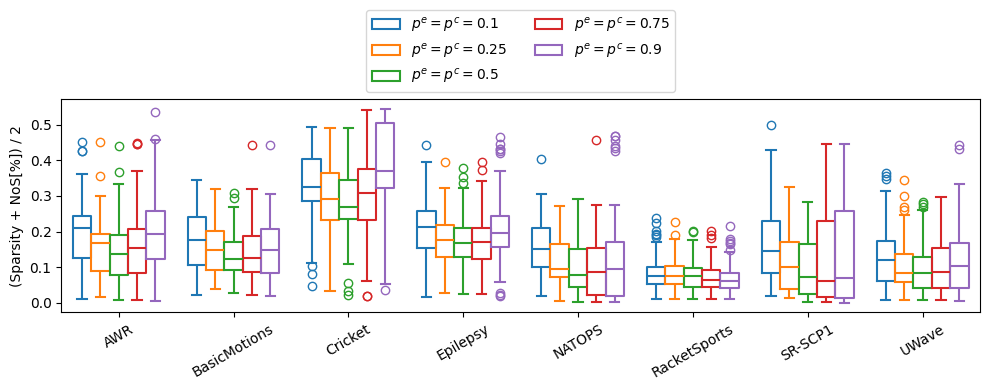

In [78]:
plt.figure(figsize=(10, 4))
ax = sns.boxplot(data=aux_df, x="Dataset", y="(Sparsity + NoS[%]) / 2", hue="Method", fill=False)
# ax.legend(loc='upper right')
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=2, title=None)
ax.set(xlabel=None)
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('./experiments/results/ablation_indep_ec_mut.PNG', dpi=300)

In [68]:
times_df = pd.DataFrame()
for dataset in DATASETS:
    X_train, y_train, X_test, y_test = data_dict[dataset]
    dataset_ts_len, dataset_nchannels = X_train.shape[1], X_train.shape[2]
    dataset_times = results_all_datasets_df[results_all_datasets_df["dataset"] == dataset][['times', 'method', 'dataset']]
    dataset_times["dataset_ts_len"] = dataset_ts_len
    dataset_times["dataset_nchannels"] = dataset_nchannels
    times_df = pd.concat([times_df, dataset_times])
times_df = times_df.rename(columns={"times": "Seconds", "dataset_ts_len": "Time series length", "dataset_nchannels": "Channels"})

In [69]:
# times_df.groupby(["dataset", "method"]).mean()

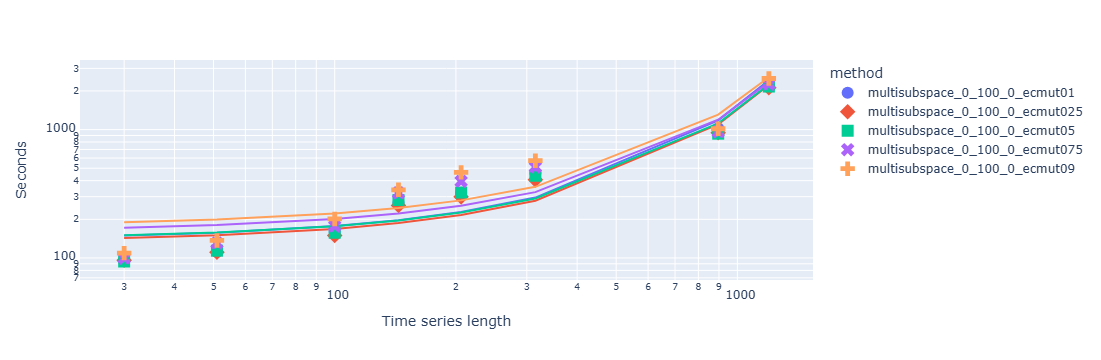

In [70]:
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'multivariate_times_length',
    'height': 400,
    'width': 1200,
    'scale':9 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

fig = px.scatter(
    times_df.groupby(["dataset", "method"]).mean().reset_index(), 
    x="Time series length", y="Seconds", color="method", symbol="method", trendline="ols", trendline_options=dict(log_y=True), log_x=True, log_y=True)
fig.update_traces(marker={'size': 12})
fig.show(config=config)



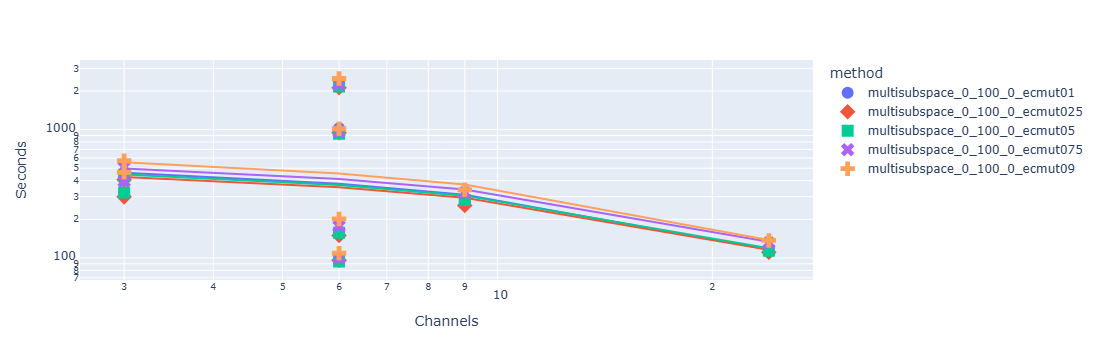

In [71]:
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'multivariate_times_channels',
    'height': 400,
    'width': 1200,
    'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

fig = px.scatter(
    times_df[times_df["dataset"]!="PEMS-SF"].groupby(["dataset", "method"]).mean().reset_index(), 
    x="Channels", y="Seconds", color="method", symbol="method", trendline="ols", trendline_options=dict(log_y=True), log_x=True, log_y=True)
fig.update_traces(marker={'size': 12})
fig.show(config=config)

In [72]:
times_df

Seconds                         method             dataset  Time series length  Channels
0   112.334364  multisubspace_0_100_0_ecmut05        BasicMotions                 100         6
1   171.441896  multisubspace_0_100_0_ecmut05        BasicMotions                 100         6
2   172.796110  multisubspace_0_100_0_ecmut05        BasicMotions                 100         6
3   175.229780  multisubspace_0_100_0_ecmut05        BasicMotions                 100         6
4   149.939452  multisubspace_0_100_0_ecmut05        BasicMotions                 100         6
..         ...                            ...                 ...                 ...       ...
95  662.736902  multisubspace_0_100_0_ecmut01  SelfRegulationSCP1                 896         6
96  577.961578  multisubspace_0_100_0_ecmut01  SelfRegulationSCP1                 896         6
97  547.048348  multisubspace_0_100_0_ecmut01  SelfRegulationSCP1                 896         6
98  676.666864  multisubspace_0_100_0_ecmut01  SelfRegulationSCP1                 896         6
99  329.954730  multisubspace_0_100_0_ecmut01  SelfRegulationSCP1                 896         6

[3560 rows x 5 columns]

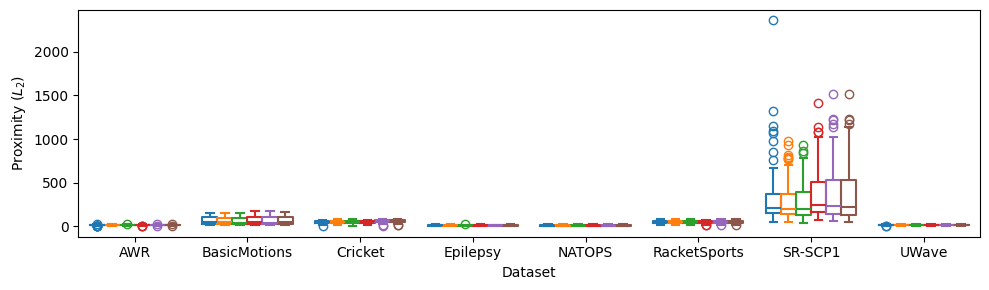

In [29]:
plt.figure(figsize=(10, 3))
ax = sns.boxplot(data=aux_df[aux_df["Dataset"]!="PenDigits"], x="Dataset", y='Proximity ($L_2$)', hue="Method", fill=False)
# ax.legend(loc='upper right')
# plt.legend(fontsize=8)
plt.legend([],[], frameon=False)
plt.tight_layout()

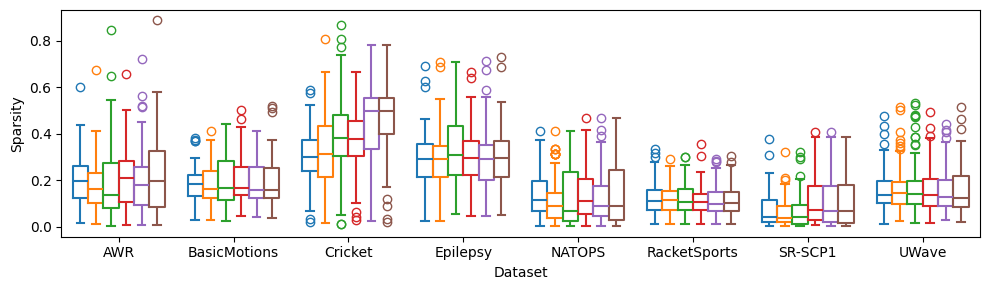

In [30]:
plt.figure(figsize=(10, 3))
ax = sns.boxplot(data=aux_df[aux_df["Dataset"]!="PenDigits"], x="Dataset", y='Sparsity', hue="Method", fill=False)
# ax.legend(loc='upper right')
# plt.legend(fontsize=8)
plt.legend([],[], frameon=False)
plt.tight_layout()

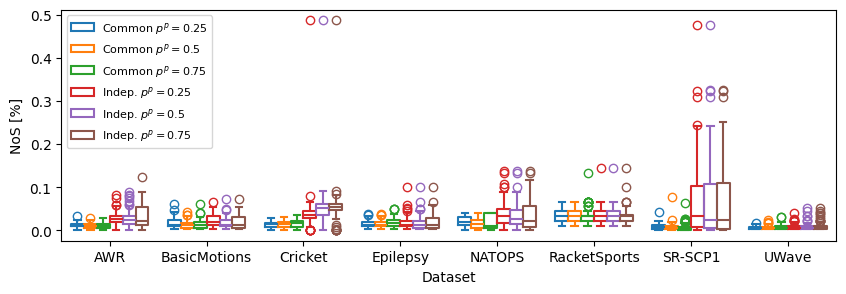

In [31]:
plt.figure(figsize=(10, 3))
ax = sns.boxplot(data=aux_df[aux_df["Dataset"]!="PenDigits"], x="Dataset", y='NoS [%]', hue="Method", fill=False)
ax.legend(loc='upper right')
plt.legend(fontsize=8)


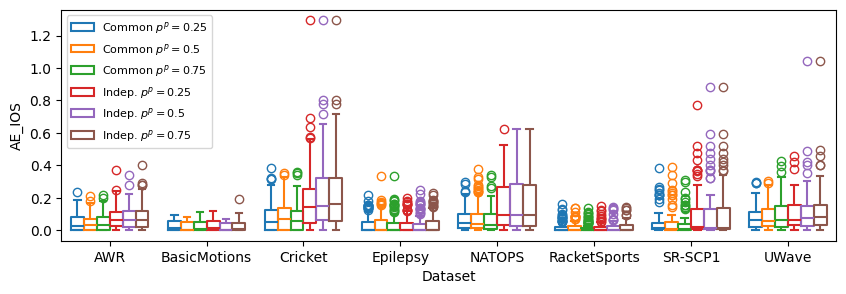

In [32]:
plt.figure(figsize=(10, 3))
ax = sns.boxplot(data=aux_df[aux_df["Dataset"]!="PenDigits"], x="Dataset", y='AE_IOS', hue="Method", fill=False)
ax.legend(loc='upper right')
plt.legend(fontsize=8)


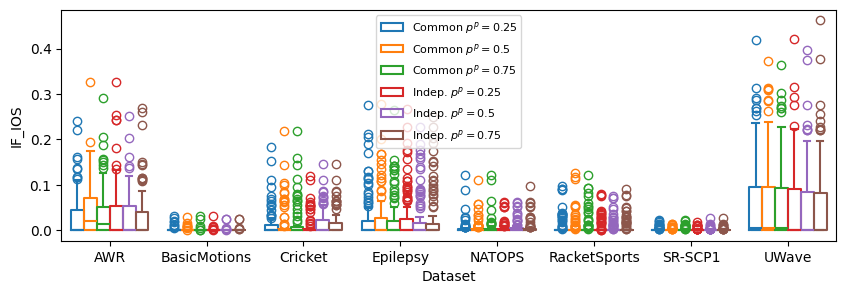

In [33]:
plt.figure(figsize=(10, 3))
ax = sns.boxplot(data=aux_df[aux_df["Dataset"]!="PenDigits"], x="Dataset", y='IF_IOS', hue="Method", fill=False)
ax.legend(loc='upper right')
plt.legend(fontsize=8)


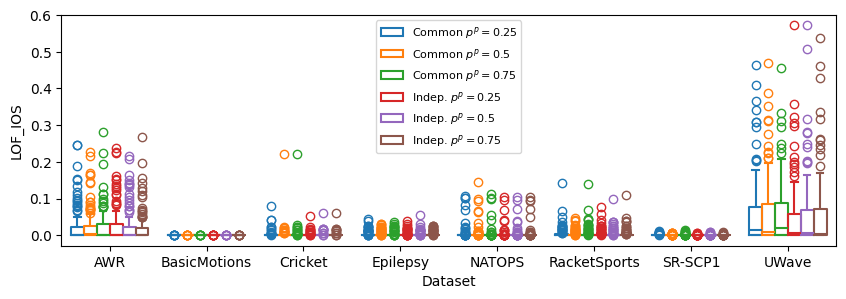

In [34]:
plt.figure(figsize=(10, 3))
ax = sns.boxplot(data=aux_df[aux_df["Dataset"]!="PenDigits"], x="Dataset", y='LOF_IOS', hue="Method", fill=False)
# ax.legend(bbox_to_anchor=(1.04, 1), loc="upper right")
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.5, 1))
plt.legend(fontsize=8)

# Counterfactual visualization

In [11]:
import math
def plot_comp_cfs(x_orig, possible_nuns, x_cfs_dict):
    
    # Calculate auxiliary variables
    method_names = list(x_cfs_dict.keys())
    x_cfs = list(x_cfs_dict.values())
    length = x_orig.shape[0]
    n_channels = x_orig.shape[1]

    # Define outer grid
    fig = plt.figure(figsize=(18, 12), dpi=600)
    grid_columns = 2
    grid_rows = math.ceil(len(x_cfs) / grid_columns)
    outer_grid = gridspec.GridSpec(grid_rows, grid_columns, wspace=0.2, hspace=0.3)

    # Iterate through outer grid plots
    for m, outer in enumerate(outer_grid):
        try:
            # Get change mask 
            x_cf = x_cfs[m]
            method_name = method_names[m]
            """# Get nuns used by the method depending on the name
            if "gknn" in method_name:
                nun_example = possible_nuns["gknn"]
            elif "iknn" in method_name:
                nun_example = possible_nuns["iknn"]
            else:
                raise ValueError('Not detected NUN finding procedure in name. Method name must contain "gknn" or "iknn"')"""
            # found_counterfactual_mask = (x_orig != x_cf.reshape(1, length, n_channels)).astype(int)
            proximity_values = np.abs(x_orig - x_cf.reshape(1, length, n_channels))
            found_counterfactual_mask = (proximity_values > np.abs(x_orig)/proximity_values*0.0001).astype(int)
            diff_mask = np.diff(found_counterfactual_mask, prepend=0, append=0, axis=1)
        except IndexError:
            break
    
        # Create inner grid
        inner_grid = gridspec.GridSpecFromSubplotSpec(n_channels, 1, wspace=0.2, hspace=0.2, subplot_spec=outer)
        sub_channel_axs = []
        for i in range(n_channels):
            ax = plt.Subplot(fig, inner_grid[i])
            # ax.plot(nun_example.reshape(1, length, n_channels)[:, :, i].flatten(), color='grey')
            ax.plot(x_cf.reshape(1, length, n_channels)[:, :, i].flatten(), color='red')
            ax.plot(x_orig.reshape(1, length, n_channels)[:, :, i].flatten(), color="#332288")
            # Set title if first channel
            if i == 0:
                ax.set_title(method_name)
            
            # Add fill to changes
            starts = np.clip( np.where(diff_mask[0, :, i].flatten() == 1)[0] - 1 , 0, length)
            ends = np.where(diff_mask[0, :, i].flatten() == -1)[0]
            # Iterate over the mask segments and fill them with red color
            for i in range(0, len(starts)):
                start_idx = starts[i]
                end_idx = ends[i]
                # plt.fill_between(comp_df.iloc[start_idx:end_idx].index, comp_df.min(), comp_df.max(), color='red', alpha=0.7)
                ax.axvspan(start_idx, end_idx, alpha=0.2, color='red')
            
            # Add ax to list of subplots
            fig.add_subplot(ax)
            sub_channel_axs.append(ax)

    # Plot figure
    fig.legend(
        sub_channel_axs,     # The line objects
        labels=['x_cf', 'x_orig'],   # The labels for each line
        loc='center',
        prop={'size': 12}
    )
    plt.tight_layout()
    plt.show()
    # plt.savefig(f'./experiments/results/examples_cfs_{dataset}_instance_{instance_index}.png', dpi=600)



In [12]:
dataset = "SelfRegulationSCP1"
aux_results_dataset = results_all_datasets_df[results_all_datasets_df["dataset"]==dataset].sort_values(by="ii")

with pd.option_context("display.max_rows", None,): 
    display(aux_results_dataset[aux_results_dataset["method"]=="COMTE"])

Empty DataFrame
Columns: [ii, nchanges, sparsity, L1, L2, proba, valid, nuns_valid, outlier_score, increase_outlier_score, subsequences, subsequences %, times, method, best cf index, order, dataset]
Index: []

In [15]:
# methods = ["subspace_grouped", "subspace_v2_grouped", "subspace_individual", "subspace_v2_individual"]
common_index_instance = 0

In [16]:
# Get data
X_train, y_train, X_test, y_test = data_dict[dataset]
common_indexes = common_test_indexes_dict[dataset]
instance_index = common_indexes[common_index_instance]

# Get common cfs calculated for all method
x_orig = X_test[instance_index]

# Get possible NUNs
possible_nuns = possible_nuns_dict[dataset]
possible_nuns_instance = {type: possible_nuns[type][instance_index] for type in ["gknn", "iknn"]}

# Get original class and desired class
original_class = original_classes_dict[dataset][instance_index]
desired_class = desired_classes_dict[dataset][instance_index]

# Get the cf calculated for all methods
sol_cfs_methods = {}
sol_methods = methods_cfs_dict[dataset]
for method, solutions in sol_methods.items():
    if 'cfs' in solutions[0]:
        counterfactuals = [solution['cfs'] for solution in solutions]
    else:
        counterfactuals = [solution['cf'] for solution in solutions] 
    # Extract best counterfactual in case of multi objective
    counterfactual = counterfactuals[common_index_instance]
    # Extract best index solution
    aux_results_dataset_method = aux_results_dataset[aux_results_dataset["method"] == method]
    best_cf_index = aux_results_dataset_method.iloc[common_index_instance]["best cf index"]
    best_cf = counterfactual[best_cf_index]
    best_cf = np.expand_dims(best_cf, axis=0)
    # Append to dictionary
    sol_cfs_methods[method] = best_cf
    
# Show result
print(f'Sample {instance_index}: true class {y_test[instance_index]}, x_orig predicted {original_class}, desired_class  {desired_class}')
plot_comp_cfs(x_orig, possible_nuns_instance, sol_cfs_methods)

Sample 0: true class 1, x_orig predicted 1, desired_class  0


C:\Users\mrefoyo\AppData\Local\Temp\ipykernel_6508\3847629260.py:31: RuntimeWarning: divide by zero encountered in divide
  found_counterfactual_mask = (proximity_values > np.abs(x_orig)/proximity_values*0.0001).astype(int)
C:\Users\mrefoyo\AppData\Local\Temp\ipykernel_6508\3847629260.py:31: RuntimeWarning: invalid value encountered in divide
  found_counterfactual_mask = (proximity_values > np.abs(x_orig)/proximity_values*0.0001).astype(int)
C:\Users\mrefoyo\AppData\Local\Temp\ipykernel_6508\3847629260.py:63: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(
C:\Users\mrefoyo\AppData\Local\Temp\ipykernel_6508\3847629260.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [ ]:
# Create plot with examples of each method in each dataset

In [ ]:
# CBF: 1, 2, 10, 18, 19
# chinatown: 3, 7, 19
# coffee: 1, 3, 9, 16
# ECG200: 0, 13
# gunpoint: 9, 10, 15 (pesimos en general)
dataset_samples = [('CBF', 2), ('chinatown', 19), ('coffee', 3), ('ECG200', 13), ('gunpoint', 15)]
methods_trad_dict = {"wcf_ng": "W-CF", "ng": "NG", "ab_cf": "AB-CF", "subspace": "Sub-SpaCE"}
methods = list(methods_trad_dict.keys())
include_nun_list = [False, False, False, False]

In [ ]:
from collections import OrderedDict

# Define outer grid
fig = plt.figure(figsize=(16, 6))
grid_rows = len(methods)
grid_columns = len(dataset_samples)
outer_grid = gridspec.GridSpec(grid_rows, grid_columns, wspace=0, hspace=0)

# Iterate through outer grid plots
for i_outer, outer in enumerate(outer_grid):
    i_dataset = i_outer % grid_columns
    dataset, instance = dataset_samples[i_dataset]
    column_title = f'{dataset} instance {instance}'
    
    X_train, y_train, X_test, y_test = data_dict[dataset]
    nuns_idx = nuns_idx_dict[dataset]
    sol_cfs_methods = sol_cfs_dict[dataset]
    sol_cfs_methods = {method: sol_cfs_methods[method][instance]['cf'] for method in methods}

    # Calculate auxiliary variables
    method_names = list(sol_cfs_methods.keys())
    x_cfs = list(sol_cfs_methods.values())
    x_orig = X_test[instance]
    nun_example = X_train[nuns_idx[instance]]
    length = x_orig.shape[0]
    n_channels = x_orig.shape[1]

    # get method m
    m = i_outer // grid_columns
    try:
        # Get change mask 
        x_cf = x_cfs[m]
        method_name = method_names[m]
        found_counterfactual_mask = (x_orig != x_cf.reshape(1, length, n_channels)).astype(int)
        diff_mask = np.diff(found_counterfactual_mask, prepend=0, append=0, axis=1)
    except IndexError:
        break

    # Create inner grid
    inner_grid = gridspec.GridSpecFromSubplotSpec(n_channels, 1, wspace=0, hspace=0, subplot_spec=outer)
    sub_channel_axs = []
    for i in range(n_channels):
        ax = plt.Subplot(fig, inner_grid[i])
        if include_nun_list[m]:
            ax.plot(nun_example.reshape(1, length, n_channels)[:, :, i].flatten(), color='grey')
        ax.plot(x_cf.reshape(1, length, n_channels)[:, :, i].flatten(), color='red')
        ax.plot(x_orig.reshape(1, length, n_channels)[:, :, i].flatten(), color="#332288")
        # ax.axis("off")
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add fill to changes
        starts = np.clip( np.where(diff_mask[0, :, i].flatten() == 1)[0] - 1 , 0, length)
        ends = np.where(diff_mask[0, :, i].flatten() == -1)[0]
        # Iterate over the mask segments and fill them with red color
        for i in range(0, len(starts)):
            start_idx = starts[i]
            end_idx = ends[i]
            # plt.fill_between(comp_df.iloc[start_idx:end_idx].index, comp_df.min(), comp_df.max(), color='red', alpha=0.7)
            ax.axvspan(start_idx, end_idx, alpha=0.2, color='red')
        
        # Set column titles
        if m == 0:
            ax.set_title(column_title)
        if i_dataset == 0:
            ax.set_ylabel(methods_trad_dict[method_name], size='large')
        # Add ax to list of subplots
        fig.add_subplot(ax)
        sub_channel_axs.append(ax)

# Plot figure
plt.tight_layout()
"""fig.legend(
    sub_channel_axs,     # The line objects
    labels=['$x^n$', 'x', "x'"],   # The labels for each line
    loc='lower center',
    # loc='center right',
    prop={'size': 14},
    ncol=3
)"""
# plt.show()
# plt.savefig('./experiments/results/examples_cfs.png', dpi=300)


In [ ]:
from collections import OrderedDict

# Define outer grid
fig = plt.figure(figsize=(12, 12))
grid_rows = len(dataset_samples)
grid_columns = len(methods)
outer_grid = gridspec.GridSpec(grid_rows, grid_columns, wspace=0, hspace=0)

# Iterate through outer grid plots
for i_outer, outer in enumerate(outer_grid):
    i_dataset = i_outer // grid_columns
    dataset, instance = dataset_samples[i_dataset]
    
    X_train, y_train, X_test, y_test = data_dict[dataset]
    nuns_idx = nuns_idx_dict[dataset]
    sol_cfs_methods = sol_cfs_dict[dataset]
    sol_cfs_methods = {method: sol_cfs_methods[method][instance]['cf'] for method in methods}

    # Calculate auxiliary variables
    method_names = list(sol_cfs_methods.keys())
    x_cfs = list(sol_cfs_methods.values())
    x_orig = X_test[instance]
    nun_example = X_train[nuns_idx[instance]]
    length = x_orig.shape[0]
    n_channels = x_orig.shape[1]

    # get method m
    m = i_outer % grid_columns
    try:
        # Get change mask 
        x_cf = x_cfs[m]
        method_name = method_names[m]
        found_counterfactual_mask = (x_orig != x_cf.reshape(1, length, n_channels)).astype(int)
        diff_mask = np.diff(found_counterfactual_mask, prepend=0, append=0, axis=1)
    except IndexError:
        break
    
    # Create inner grid
    inner_grid = gridspec.GridSpecFromSubplotSpec(n_channels, 1, wspace=0, hspace=0, subplot_spec=outer)
    sub_channel_axs = []
    for i in range(n_channels):
        ax = plt.Subplot(fig, inner_grid[i])
        if include_nun_list[m]:
            ax.plot(nun_example.reshape(1, length, n_channels)[:, :, i].flatten(), color='grey')
        ax.plot(x_cf.reshape(1, length, n_channels)[:, :, i].flatten(), color='red')
        ax.plot(x_orig.reshape(1, length, n_channels)[:, :, i].flatten(), color="#332288")
        # ax.axis("off")
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add fill to changes
        starts = np.clip( np.where(diff_mask[0, :, i].flatten() == 1)[0] - 1 , 0, length)
        ends = np.where(diff_mask[0, :, i].flatten() == -1)[0]
        # Iterate over the mask segments and fill them with red color
        for i in range(0, len(starts)):
            start_idx = starts[i]
            end_idx = ends[i]
            # plt.fill_between(comp_df.iloc[start_idx:end_idx].index, comp_df.min(), comp_df.max(), color='red', alpha=0.7)
            ax.axvspan(start_idx, end_idx, alpha=0.2, color='red')
        
        # Set column titles
        column_title = methods_trad_dict[method_name]
        # row_title = f'{dataset} \n instance {instance}'
        row_title = f'{dataset} [{instance}]'
        if m == 0:
            ax.set_ylabel(row_title, fontsize=16, rotation=90)
        if i_dataset == 0:
            ax.set_title(column_title, fontsize=18)
            
        # Add ax to list of subplots
        fig.add_subplot(ax)
        sub_channel_axs.append(ax)

# Plot figure
plt.tight_layout()
"""fig.legend(
    sub_channel_axs,     # The line objects
    labels=['$x^n$', 'x', "x'"],   # The labels for each line
    # loc='lower center',
    loc='center right',
    prop={'size': 18},
    ncol=1
)"""
# plt.show()
plt.savefig('./experiments/results/examples_cfs.png', dpi=300)
